In [1]:
%%capture
!pip3 install tensorflow==2.0.0-beta1

# Load the TensorBoard notebook extension
# Restart the jupyter notebook if you just installed TF 2.0 Beta
%reload_ext tensorboard

In [2]:
import tensorflow as tf
import matplotlib.pyplot as plt
import numpy as np
import gym
import datetime
from tqdm import tqdm
import logging
import random

In [3]:
!rm -rf ./logs/

# Go Environment
Train on a small board with heuristic reward for fast training and efficient debugging

In [4]:
%%capture
!pip3 install -e gym-go

In [5]:
go_env = gym.make('gym_go:go-v0', size='S', reward_method='heuristic')

In [6]:
BOARD_SIZE = 7

# Machine Learning Models
Actor-Critic method

In [7]:
from tensorflow.keras import layers

In [8]:
def make_actor_critic(mode):
    assert mode == 'actor' or mode == 'critic'
    
    inputs = layers.Input(shape=(BOARD_SIZE, BOARD_SIZE, 4), name="board")
    valid_inputs = layers.Input(shape=(BOARD_SIZE, BOARD_SIZE), name="valid_board_moves")
    
    # Dense block
    num_layers = 5
    growth_rate = 4
    x = inputs
    for i in range(num_layers):
        y = tf.keras.Sequential([
            layers.Conv2D(filters=4, kernel_size=5, padding="same", bias_initializer='ones'),
            layers.BatchNormalization(),
            layers.ReLU(),
        ], name='dense_layer_{}'.format(i))(x)
        x = layers.Concatenate()([x,y])
    
    board_distr = layers.Conv2D(filters=1, kernel_size=5, padding="same", name="board_distr")(x)
    
    if mode == 'actor':
        board_distr = layers.Reshape((BOARD_SIZE**2,), name="board_distr_1d")(board_distr)
        board_distr = layers.Softmax(name="board_distr_softmax")(board_distr)
        
    board_distr = layers.Reshape((BOARD_SIZE, BOARD_SIZE), name="board_distr_2d")(board_distr)
    board_distr = layers.Multiply(name="valid_board_distr")([board_distr, valid_inputs])
    
    pass_value = layers.Conv2D(filters=1, kernel_size=BOARD_SIZE, padding="valid",
                              activation="sigmoid" if mode == 'actor' else None, name="pass_value")(x)
    pass_value = layers.Reshape((1,), name="pass_value_reshape")(pass_value)
    
    model = tf.keras.Model(inputs=[inputs, valid_inputs], outputs=[board_distr, pass_value], name=mode)
    return model

In [9]:
actor = make_actor_critic('actor')

In [10]:
critic = make_actor_critic(mode='critic')

In [11]:
import os
def copy_actor_critic(model, mode):
    if not os.path.exists('tmp'):
        os.mkdir('tmp/')
        
    model.save_weights('tmp/tmp_model.h5')
    clone = make_actor_critic(mode=mode)
    clone.load_weights('tmp/tmp_model.h5')
    return clone

In [12]:
opponent = copy_actor_critic(actor, 'actor')
target_critic = copy_actor_critic(critic, 'critic')

In [13]:
state = go_env.reset()
state, reward, done, info = go_env.step((3,5))
state, reward, done, info = go_env.step((5,3))

In [14]:
def plot_state(state, channels_last=False):
    plt.figure()
    for i, (layer, name) in enumerate(zip([state[[0,1,3]].transpose(1,2,0).astype(np.float), state[2]] if not channels_last else 
                                          [state[:,:,[0,1,3]].astype(np.float), state[:,:,2]], 
                                          ['board', 'invalid'])):
        plt.subplot(1,4,i+1)
        plt.title(name)
        plt.imshow(layer)
    plt.tight_layout()

Tensorflow expects images to be `channels last`. 

This can be adapted to with `tranpose`.


Ensure the `transpose` function doesn't change anything visually

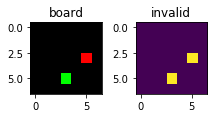

In [15]:
plot_state(state, channels_last=False)

In [16]:
state = state.transpose(1,2,0).reshape(1, BOARD_SIZE, BOARD_SIZE, 4)

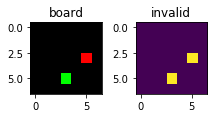

In [17]:
plot_state(state[0], channels_last=True)

### Initialization of models should be random

In [18]:
board_probs, pass_decision = actor([state.astype(np.float32), 1 - state[:,:,:,2].astype(np.float32)])

In [19]:
board_vals, pass_vals = critic([state.astype(np.float32), 1 - state[:,:,:,2].astype(np.float32)])

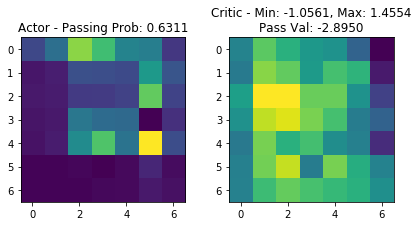

In [20]:
plt.subplot(1,2,1)
plt.title('Actor - Passing Prob: {:.4f}'.format(pass_decision[0][0]))
plt.imshow(board_probs[0])
plt.subplot(1,2,2)
plt.title('Critic - Min: {:.4f}, Max: {:.4f}\nPass Val: {:.4f}'.
          format(tf.math.reduce_min(board_vals[0]), 
                 tf.math.reduce_max(board_vals[0]), 
                 pass_vals[0][0]))
plt.imshow(board_vals[0])
plt.tight_layout()

# Training Setup

### Hyperparameters

In [21]:
NUM_EPISODES = 1000
BATCH_SIZE = 128
REPLAY_MEM_SIZE = 256
OPPONENT_UPDATE = 100 
EPSILON = 1
EPSILON_DECAY = 0.995
EPSILON_MIN = 0.1
GAMMA = 0.95
TARGET_UPDATE = 1 # number of episodes to update the target critic model
ACTOR_LEARNING_RATE = 1e-3
CRITIC_LEARNING_RATE = 1e-2

In [22]:
from collections import deque

In [23]:
replay_mem = deque(maxlen=int(REPLAY_MEM_SIZE))

### Metrics and Tensorboard

Metrics

In [24]:
actor_metrics = {}
for metric_key in ['loss']:
    actor_metrics[metric_key] = tf.keras.metrics.Mean('actor_{}'.format(metric_key), dtype=tf.float32)

critic_metrics = {}
for metric_key in ['loss']:
    critic_metrics[metric_key] = tf.keras.metrics.Mean('critic_{}'.format(metric_key), dtype=tf.float32)

Tensorboard

In [25]:
summary_writers = {}
current_time = datetime.datetime.now().strftime("%Y%m%d-%H%M%S")
for summary_key in ['main']:
    log_dir = 'logs/actor_critic/{}/{}'.format(current_time, summary_key)
    summary_writers[summary_key] = tf.summary.create_file_writer(log_dir)

### Functions

In [26]:
from sklearn import preprocessing
def random_weighted_action(state, pass_prob, board_weights):
    # Decide with 1 / BOARD_SIZE ** 2 chance to pass (pass if we have to)
    if np.random.uniform() < pass_prob or np.isnan(board_weights).any() or np.sum(board_weights) <= 0:
        action = None
    else:
        board_weights_sum = np.sum(board_weights)
        board_weights = tf.reshape(board_weights, (1,BOARD_SIZE**2))
        board_weights = preprocessing.normalize(board_weights, norm='l1')
        board_weights = board_weights.reshape((BOARD_SIZE**2,))
        action_1d = np.random.choice(np.arange(BOARD_SIZE**2), p=board_weights)
        action = (action_1d // BOARD_SIZE, action_1d % BOARD_SIZE)
    return action

In [27]:
def get_action(policy, state, epsilon):
    """
    Gets an action based on exploration/exploitation
    """
    epsilon_choice = np.random.uniform()
    if epsilon_choice < EPSILON:
        # Random move
        logging.debug("Exploring a random move")
        board_weights = 1 - state[2]
        board_weights = board_weights / np.sum(board_weights)
        action = random_weighted_action(state, 
                        pass_prob=1/BOARD_SIZE**2, 
                        board_weights=board_weights)
    else:
        # policy makes a move
        logging.debug("Exploiting policy's move")
        if state.shape[0] == 4:
            state = state.transpose(1,2,0)
        reshaped_state = state.reshape(1, BOARD_SIZE, BOARD_SIZE, 4).astype(np.float32)
        act_prob_distr, pass_decision = policy([reshaped_state, 1-reshaped_state[:,:,:,2]])
        
        action = random_weighted_action(state, pass_prob=pass_decision, 
                                        board_weights=act_prob_distr)
        
    return action

In [28]:
def get_value_for_action(board_values, passing_values, actions):
    '''
    Get value from board_values based on action, or take the passing_values if the action is None
    '''
    action_values = tf.gather_nd(board_values, [(i, a[0], a[1]) if a is not None 
                                                    else (i, 0, 0) 
                                                    for i, a in enumerate(actions)])
    action_values = tf.where([a is not None for a in actions], action_values, passing_values)
    return action_values

In [29]:
def get_batch_obs(size=BATCH_SIZE):
    '''
    Get a batch of orig_states, actions, states, rewards, terminals as np array out of replay memory
    '''
    batch = random.sample(replay_mem, size)
    batch = list(zip(*batch))
    orig_states = np.array(list(batch[0]), dtype=np.float32).transpose(0,3,2,1)
    actions = np.array(list(batch[1]))
    states = np.array(list(batch[2]), dtype=np.float32).transpose(0,3,2,1)
    rewards = np.array(list(batch[3]), dtype=np.float32)
    terminals = np.array(list(batch[4]), dtype=np.uint8)
    return orig_states, actions, states, rewards, terminals
    

In [30]:
def calculate_state_vals(states, policy, actval_func):
    '''
    Get the expected value of states
    '''
    board_prob_distrs, passing_probs = policy([states, 1-states[:,:,:,2]])
    board_val_distrs, passing_vals = actval_func([states, 1-states[:,:,:,2]])
    
    passing_probs = tf.reshape(passing_probs, (-1,))
    passing_vals = tf.reshape(passing_vals, (-1,))
    
    # state value is the expected critic value based on the actor's policy
    state_vals = tf.reduce_sum(board_prob_distrs * board_val_distrs, axis=[1,2])
    state_vals = passing_probs * passing_vals + (1 - passing_probs) * state_vals
    return state_vals

In [31]:
critic_optimizer = tf.keras.optimizers.Adam(CRITIC_LEARNING_RATE)
def update_critic():
    """
    Optimizes the critic in one step and updates the critic loss metric
    """
    
    mse = tf.keras.losses.MeanSquaredError()
    
    states, actions, next_states, rewards, terminals  = get_batch_obs()
    
    # get expected values for next state
    next_state_vals = calculate_state_vals(next_states, actor, target_critic)
    
    with tf.GradientTape() as tape:
        board_val_distrs, passing_vals = critic([states, 1-states[:,:,:,2]])
        passing_vals = tf.reshape(passing_vals, (-1,))
        action_vals = get_value_for_action(board_val_distrs, passing_vals, actions)
        val_loss = mse(rewards + GAMMA * next_state_vals * (1-terminals), action_vals)
    
    critic_metrics['loss'](val_loss)
    
    # compute and apply gradients
    gradients = tape.gradient(val_loss, critic.trainable_variables)
    critic_optimizer.apply_gradients(zip(gradients, critic.trainable_variables))

In [32]:
actor_optimizer = tf.keras.optimizers.Adam(ACTOR_LEARNING_RATE)
def update_actor():
    """
    Optimizes the actor in one step and updates the critic loss metric
    """
    
    mse = tf.keras.losses.MeanSquaredError()
    
    states, actions, next_states, rewards, terminals = get_batch_obs()
    
    # State values
    state_vals = calculate_state_vals(states, actor, critic)
    
    # Next state values
    next_state_vals = calculate_state_vals(next_states, actor, critic)
    
    # Advantage values
    avntg_vals = (rewards + GAMMA * next_state_vals * (1-terminals)) - state_vals
    
    with tf.GradientTape() as tape:
        board_prob_distrs, passing_probs = actor([states, 1-states[:,:,:,2]])
        passing_probs = tf.reshape(passing_probs, (-1,))
        action_probs = get_value_for_action(board_prob_distrs, passing_probs, actions)
        avntg_loss = - tf.math.log(action_probs + 1e-6) * avntg_vals
        avntg_loss = tf.math.reduce_mean(avntg_loss)
    
    # log the loss in tensorboard
    actor_metrics['loss'](avntg_loss)
        
    # compute and apply gradients
    gradients = tape.gradient(avntg_loss, actor.trainable_variables)
    actor_optimizer.apply_gradients(zip(gradients, actor.trainable_variables))

In [33]:
def train(episode):
    """
    Plays out a game, and iteratively updates the models at each step
    """
    global EPSILON
    
    # Basic setup
    done = False
    num_of_turns = 0
    state = go_env.reset()
    max_steps = BOARD_SIZE**3
    rewards = []
    
    while not done and num_of_turns <= max_steps:
        # Copy state for memory
        orig_state = np.copy(state)
        
        action = get_action(actor, state, EPSILON)
        if action is None:
            logging.debug("Black (actor) passed")
            
        state, reward, done, info = go_env.step(action)
        num_of_turns += 1
        rewards.append(reward)
        
        # Add to memory
        replay_mem.append((orig_state, action, state, reward, done))
        
        # Update the critic and then actor if we have enough events
        if len(replay_mem) >= BATCH_SIZE:
            update_critic()        
#             update_actor()
    
            # Update exploration/exploitation
            if EPSILON > EPSILON_MIN:
                EPSILON *= EPSILON_DECAY
                logging.debug("Epsilon decayed to {}".format(EPSILON))
            
        if done:
            break
            
        # opponent makes a move
        # swap the black and white layers
        temp = np.copy(state[0])
        state[0] = state[1]
        state[1] = temp
        # get action from opponent
        action = get_action(opponent, state, epsilon=0)
        if action is None:
            logging.debug("White (opponent) passed")

        state, reward, done, info = go_env.step(action)
        num_of_turns += 1
        rewards.append(reward)
    
    # Game ended
    return num_of_turns, rewards

# Train

In [34]:
logger = logging.getLogger()
logger.setLevel(logging.INFO)

  0%|          | 0/1000 [00:00<?, ?it/s]WARNING: Logging before flag parsing goes to stderr.
I0720 16:03:24.920975 4490204608 <ipython-input-35-cf0319494b27>:10] Updated opponent
/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/ipykernel_launcher.py:10: RuntimeWarning: invalid value encountered in true_divide
  # Remove the CWD from sys.path while we load stuff.
/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/ipykernel_launcher.py:10: RuntimeWarning: invalid value encountered in true_divide
  # Remove the CWD from sys.path while we load stuff.
/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/ipykernel_launcher.py:10: RuntimeWarning: invalid value encountered in true_divide
  # Remove the CWD from sys.path while we load stuff.
/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/ipykernel_launcher.py:10: RuntimeWarning: invalid value encountered in true_divide
  # Remove the 

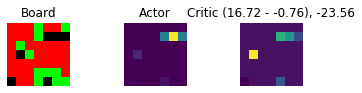

  0%|          | 1/1000 [00:07<2:09:19,  7.77s/it]

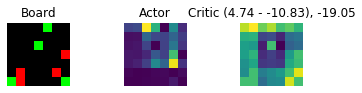

  0%|          | 2/1000 [00:10<1:41:35,  6.11s/it]

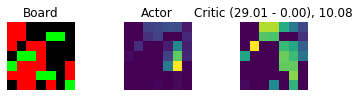

  0%|          | 3/1000 [00:12<1:22:17,  4.95s/it]

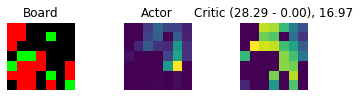

  0%|          | 4/1000 [00:15<1:15:02,  4.52s/it]

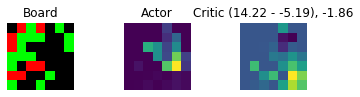

  0%|          | 5/1000 [00:16<55:10,  3.33s/it]  

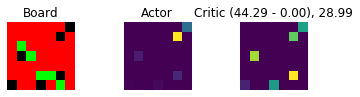

  1%|          | 6/1000 [00:17<44:29,  2.69s/it]

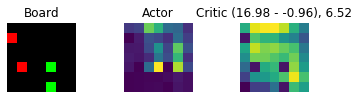

  1%|          | 7/1000 [00:18<38:06,  2.30s/it]

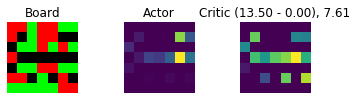

  1%|          | 8/1000 [00:19<29:23,  1.78s/it]

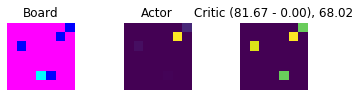

  1%|          | 9/1000 [00:20<23:47,  1.44s/it]

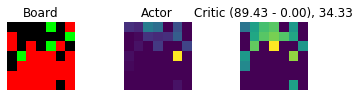

  1%|          | 10/1000 [00:20<20:57,  1.27s/it]

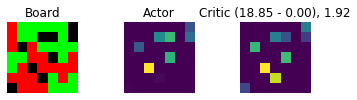

  1%|          | 11/1000 [00:21<19:08,  1.16s/it]

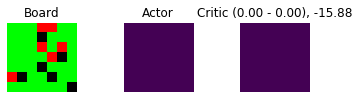

  1%|          | 12/1000 [00:22<15:43,  1.05it/s]

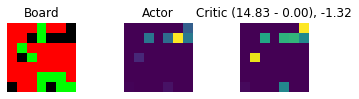

  1%|▏         | 13/1000 [00:23<15:33,  1.06it/s]

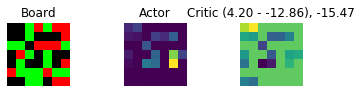

  1%|▏         | 14/1000 [00:23<13:38,  1.20it/s]

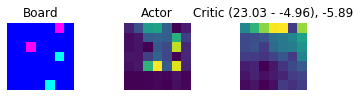

  2%|▏         | 15/1000 [00:24<12:28,  1.32it/s]

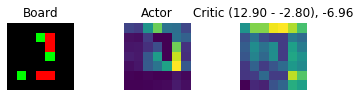

  2%|▏         | 16/1000 [00:25<14:35,  1.12it/s]

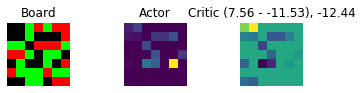

  2%|▏         | 17/1000 [00:27<19:24,  1.19s/it]

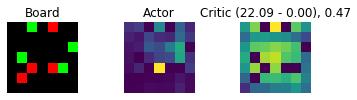

  2%|▏         | 18/1000 [00:27<15:48,  1.04it/s]

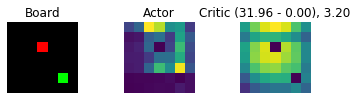

  2%|▏         | 19/1000 [00:28<14:57,  1.09it/s]

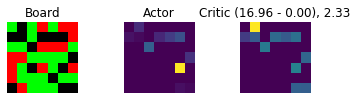

  2%|▏         | 20/1000 [00:29<16:15,  1.00it/s]

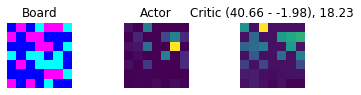

  2%|▏         | 21/1000 [00:30<14:25,  1.13it/s]

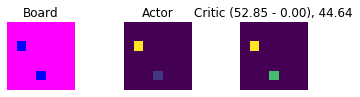

  2%|▏         | 22/1000 [00:31<12:49,  1.27it/s]

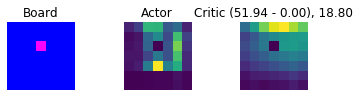

  2%|▏         | 23/1000 [00:31<11:11,  1.46it/s]

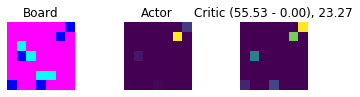

  2%|▏         | 24/1000 [00:32<12:12,  1.33it/s]

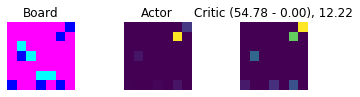

  2%|▎         | 25/1000 [00:33<12:21,  1.31it/s]

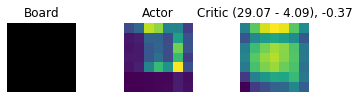

  3%|▎         | 26/1000 [00:33<11:27,  1.42it/s]

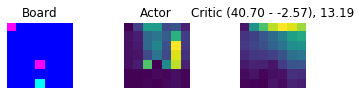

  3%|▎         | 27/1000 [00:36<21:01,  1.30s/it]

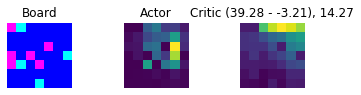

  3%|▎         | 28/1000 [00:37<18:58,  1.17s/it]

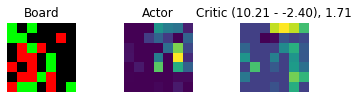

  3%|▎         | 29/1000 [00:37<16:00,  1.01it/s]

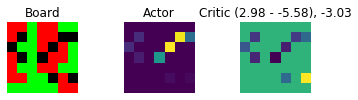

  3%|▎         | 30/1000 [00:39<16:29,  1.02s/it]

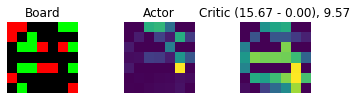

  3%|▎         | 31/1000 [00:39<15:27,  1.04it/s]

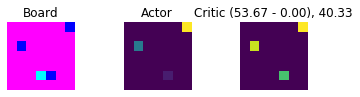

  3%|▎         | 32/1000 [00:40<13:01,  1.24it/s]

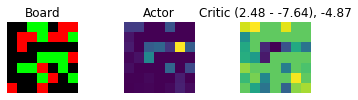

  3%|▎         | 33/1000 [00:41<12:54,  1.25it/s]

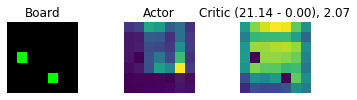

  3%|▎         | 34/1000 [00:41<12:16,  1.31it/s]

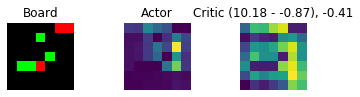

  4%|▎         | 35/1000 [00:42<10:55,  1.47it/s]

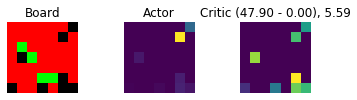

  4%|▎         | 36/1000 [00:43<13:11,  1.22it/s]

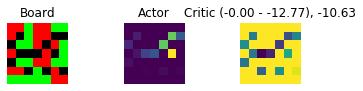

  4%|▎         | 37/1000 [00:45<16:56,  1.06s/it]

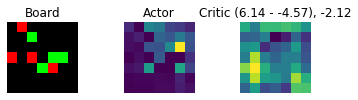

  4%|▍         | 38/1000 [00:45<15:43,  1.02it/s]

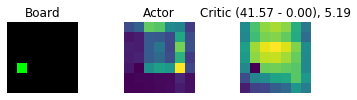

  4%|▍         | 39/1000 [00:46<16:05,  1.00s/it]

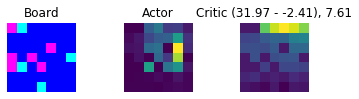

  4%|▍         | 40/1000 [00:47<13:57,  1.15it/s]

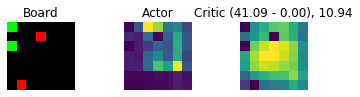

  4%|▍         | 41/1000 [00:48<12:28,  1.28it/s]

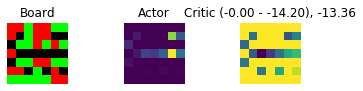

  4%|▍         | 42/1000 [00:48<10:57,  1.46it/s]

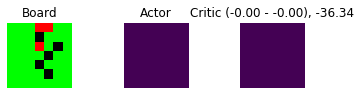

  4%|▍         | 43/1000 [00:49<11:30,  1.39it/s]

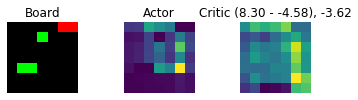

  4%|▍         | 44/1000 [00:49<10:42,  1.49it/s]

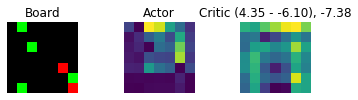

  4%|▍         | 45/1000 [00:50<11:29,  1.39it/s]

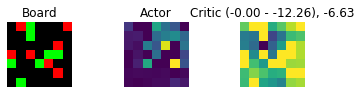

  5%|▍         | 46/1000 [00:51<12:14,  1.30it/s]

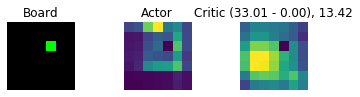

  5%|▍         | 47/1000 [00:52<12:00,  1.32it/s]

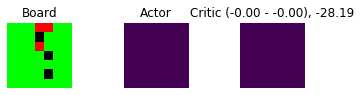

  5%|▍         | 48/1000 [00:52<11:17,  1.40it/s]

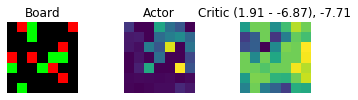

  5%|▍         | 49/1000 [00:53<11:15,  1.41it/s]

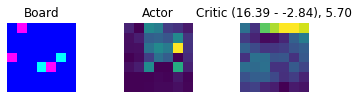

  5%|▌         | 50/1000 [00:54<10:06,  1.57it/s]

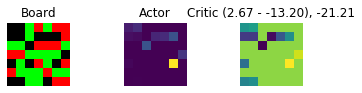

  5%|▌         | 51/1000 [00:54<09:19,  1.70it/s]

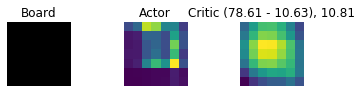

  5%|▌         | 52/1000 [00:55<08:48,  1.79it/s]

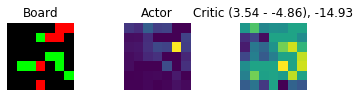

  5%|▌         | 53/1000 [00:55<08:23,  1.88it/s]

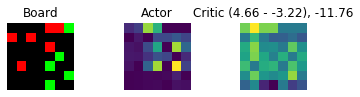

  5%|▌         | 54/1000 [00:56<08:46,  1.80it/s]

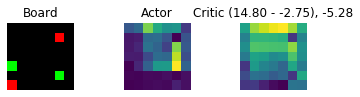

  6%|▌         | 55/1000 [00:56<08:27,  1.86it/s]

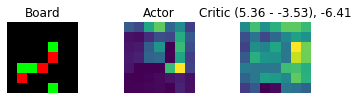

  6%|▌         | 56/1000 [00:57<08:42,  1.81it/s]

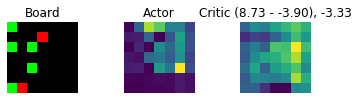

  6%|▌         | 57/1000 [00:58<10:14,  1.53it/s]

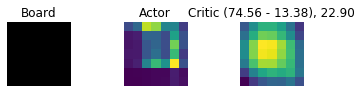

  6%|▌         | 58/1000 [00:58<09:54,  1.59it/s]

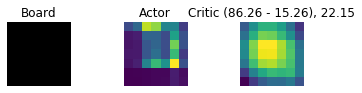

  6%|▌         | 59/1000 [00:59<11:55,  1.32it/s]

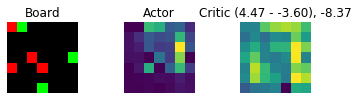

  6%|▌         | 60/1000 [01:00<11:37,  1.35it/s]

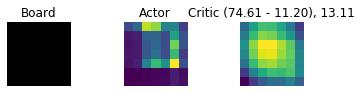

  6%|▌         | 61/1000 [01:01<13:06,  1.19it/s]

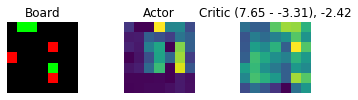

  6%|▌         | 62/1000 [01:02<11:55,  1.31it/s]

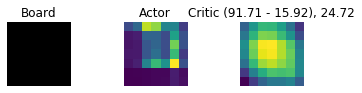

  6%|▋         | 63/1000 [01:03<13:59,  1.12it/s]

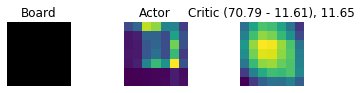

  6%|▋         | 64/1000 [01:03<12:31,  1.25it/s]

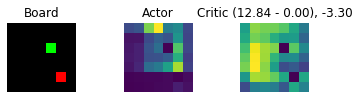

  6%|▋         | 65/1000 [01:04<12:03,  1.29it/s]

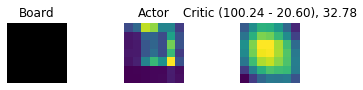

  7%|▋         | 66/1000 [01:05<12:53,  1.21it/s]

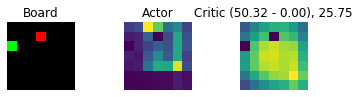

  7%|▋         | 67/1000 [01:06<11:14,  1.38it/s]

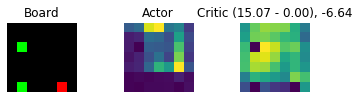

  7%|▋         | 68/1000 [01:06<11:37,  1.34it/s]

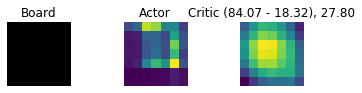

  7%|▋         | 69/1000 [01:07<10:50,  1.43it/s]

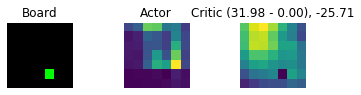

  7%|▋         | 70/1000 [01:07<10:18,  1.50it/s]

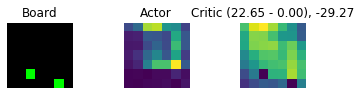

  7%|▋         | 71/1000 [01:09<12:19,  1.26it/s]

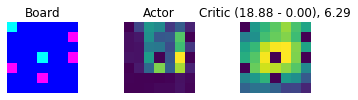

  7%|▋         | 72/1000 [01:09<12:21,  1.25it/s]

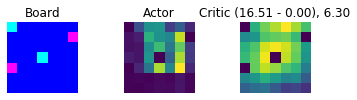

  7%|▋         | 73/1000 [01:10<10:52,  1.42it/s]

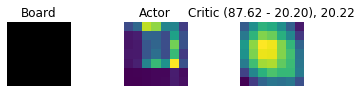

  7%|▋         | 74/1000 [01:10<10:17,  1.50it/s]

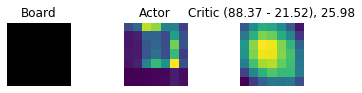

  8%|▊         | 75/1000 [01:12<12:53,  1.20it/s]

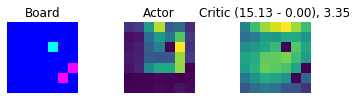

  8%|▊         | 76/1000 [01:12<11:12,  1.37it/s]

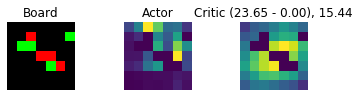

  8%|▊         | 77/1000 [01:13<10:33,  1.46it/s]

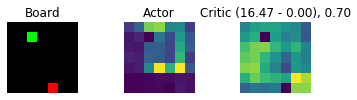

  8%|▊         | 78/1000 [01:14<11:06,  1.38it/s]

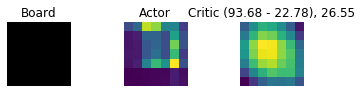

  8%|▊         | 79/1000 [01:14<11:28,  1.34it/s]

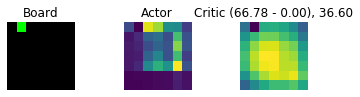

  8%|▊         | 80/1000 [01:15<10:45,  1.42it/s]

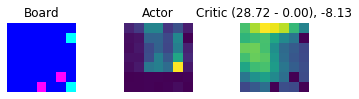

  8%|▊         | 81/1000 [01:15<09:41,  1.58it/s]

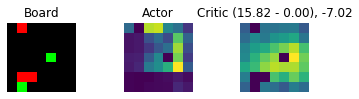

  8%|▊         | 82/1000 [01:16<09:37,  1.59it/s]

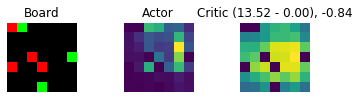

  8%|▊         | 83/1000 [01:17<09:44,  1.57it/s]

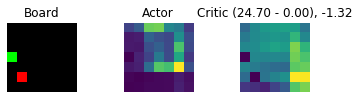

  8%|▊         | 84/1000 [01:17<10:14,  1.49it/s]

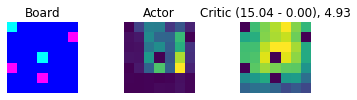

  8%|▊         | 85/1000 [01:19<13:15,  1.15it/s]

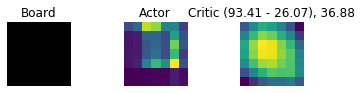

  9%|▊         | 86/1000 [01:20<12:32,  1.21it/s]

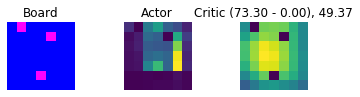

  9%|▊         | 87/1000 [01:20<11:10,  1.36it/s]

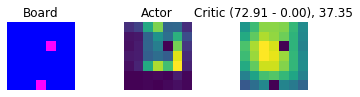

  9%|▉         | 88/1000 [01:21<12:51,  1.18it/s]

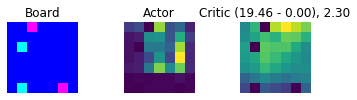

  9%|▉         | 89/1000 [01:22<11:39,  1.30it/s]

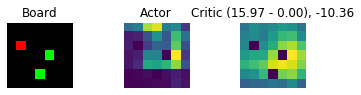

  9%|▉         | 90/1000 [01:23<11:44,  1.29it/s]

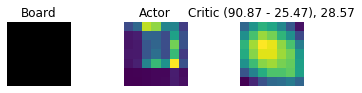

  9%|▉         | 91/1000 [01:23<10:50,  1.40it/s]

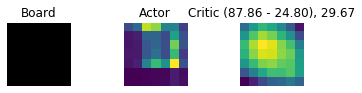

  9%|▉         | 92/1000 [01:24<11:00,  1.38it/s]

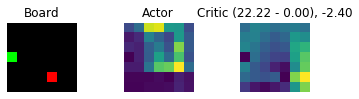

  9%|▉         | 93/1000 [01:25<11:03,  1.37it/s]

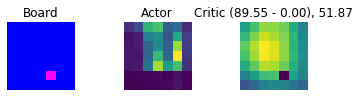

  9%|▉         | 94/1000 [01:25<10:19,  1.46it/s]

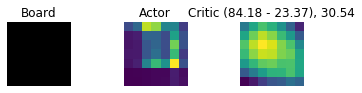

 10%|▉         | 95/1000 [01:26<10:16,  1.47it/s]

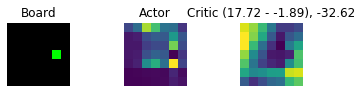

 10%|▉         | 96/1000 [01:26<10:06,  1.49it/s]

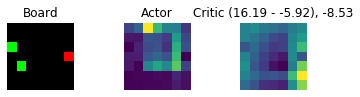

 10%|▉         | 97/1000 [01:27<10:20,  1.46it/s]

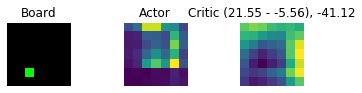

 10%|▉         | 98/1000 [01:28<09:20,  1.61it/s]

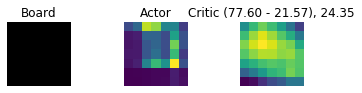

 10%|▉         | 99/1000 [01:29<10:50,  1.38it/s]

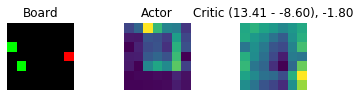

 10%|█         | 100/1000 [01:29<09:44,  1.54it/s]I0720 16:04:54.479827 4490204608 <ipython-input-35-cf0319494b27>:10] Updated opponent


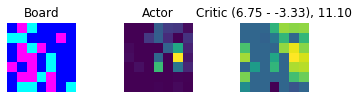

 10%|█         | 101/1000 [01:30<12:02,  1.25it/s]

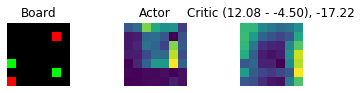

 10%|█         | 102/1000 [01:31<11:05,  1.35it/s]

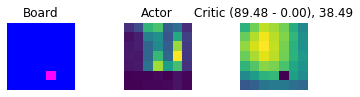

 10%|█         | 103/1000 [01:31<10:22,  1.44it/s]

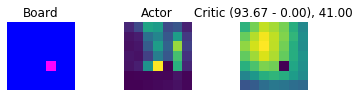

 10%|█         | 104/1000 [01:32<09:24,  1.59it/s]

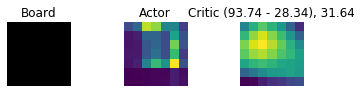

 10%|█         | 105/1000 [01:33<09:13,  1.62it/s]

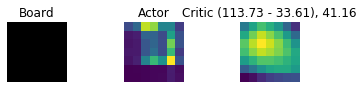

 11%|█         | 106/1000 [01:33<09:42,  1.53it/s]

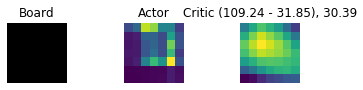

 11%|█         | 107/1000 [01:34<12:16,  1.21it/s]

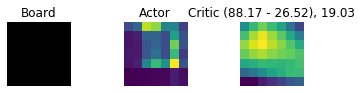

 11%|█         | 108/1000 [01:35<11:29,  1.29it/s]

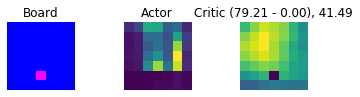

 11%|█         | 109/1000 [01:36<11:10,  1.33it/s]

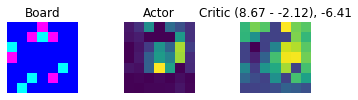

 11%|█         | 110/1000 [01:37<14:33,  1.02it/s]

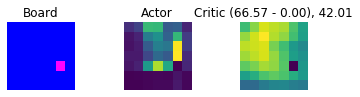

 11%|█         | 111/1000 [01:38<14:51,  1.00s/it]

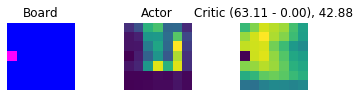

 11%|█         | 112/1000 [01:39<13:53,  1.07it/s]

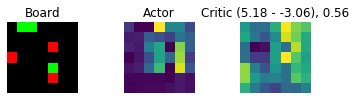

 11%|█▏        | 113/1000 [01:40<12:12,  1.21it/s]

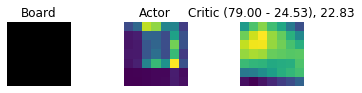

 11%|█▏        | 114/1000 [01:40<10:44,  1.37it/s]

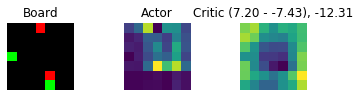

 12%|█▏        | 115/1000 [01:41<12:15,  1.20it/s]

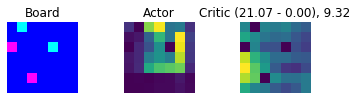

 12%|█▏        | 116/1000 [01:42<10:57,  1.34it/s]

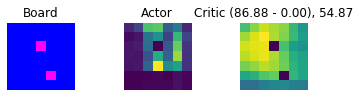

 12%|█▏        | 117/1000 [01:42<09:59,  1.47it/s]

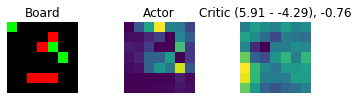

 12%|█▏        | 118/1000 [01:43<09:28,  1.55it/s]

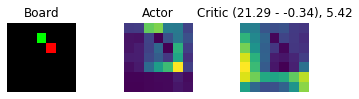

 12%|█▏        | 119/1000 [01:43<08:50,  1.66it/s]

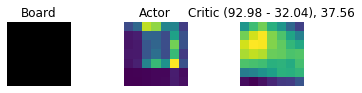

 12%|█▏        | 120/1000 [01:45<10:55,  1.34it/s]

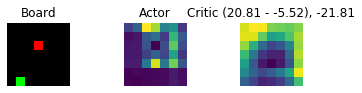

 12%|█▏        | 121/1000 [01:45<09:54,  1.48it/s]

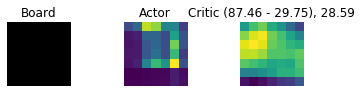

 12%|█▏        | 122/1000 [01:46<09:27,  1.55it/s]

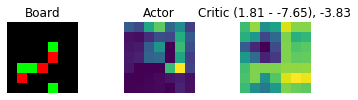

 12%|█▏        | 123/1000 [01:46<09:19,  1.57it/s]

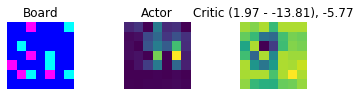

 12%|█▏        | 124/1000 [01:47<08:40,  1.68it/s]

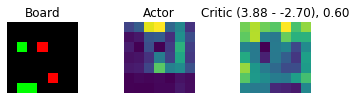

 12%|█▎        | 125/1000 [01:47<08:17,  1.76it/s]

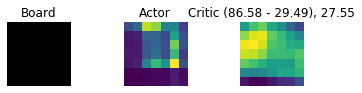

 13%|█▎        | 126/1000 [01:48<08:37,  1.69it/s]

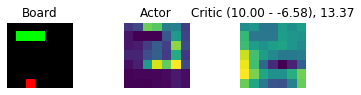

 13%|█▎        | 127/1000 [01:49<08:36,  1.69it/s]

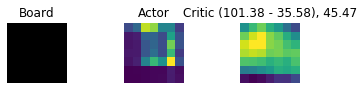

 13%|█▎        | 128/1000 [01:49<08:38,  1.68it/s]

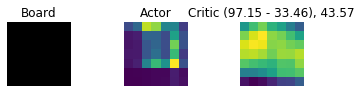

 13%|█▎        | 129/1000 [01:50<09:34,  1.52it/s]

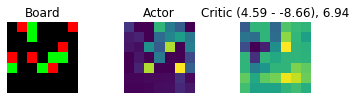

 13%|█▎        | 130/1000 [01:51<09:26,  1.54it/s]

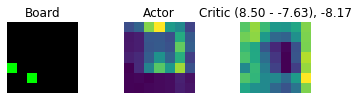

 13%|█▎        | 131/1000 [01:51<09:49,  1.47it/s]

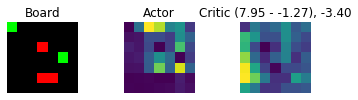

 13%|█▎        | 132/1000 [01:53<12:24,  1.17it/s]

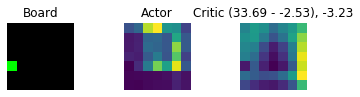

 13%|█▎        | 133/1000 [01:53<10:45,  1.34it/s]

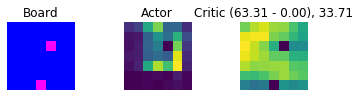

 13%|█▎        | 134/1000 [01:54<09:36,  1.50it/s]

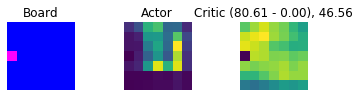

 14%|█▎        | 135/1000 [01:54<08:47,  1.64it/s]

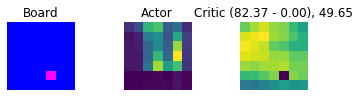

 14%|█▎        | 136/1000 [01:55<08:15,  1.74it/s]

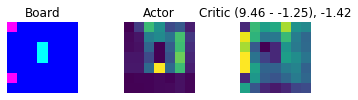

 14%|█▎        | 137/1000 [01:55<08:02,  1.79it/s]

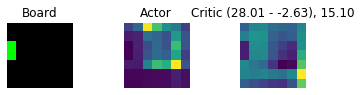

 14%|█▍        | 138/1000 [01:56<08:04,  1.78it/s]

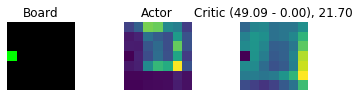

 14%|█▍        | 139/1000 [01:56<08:03,  1.78it/s]

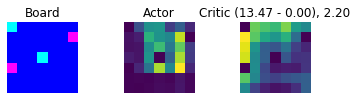

 14%|█▍        | 140/1000 [01:57<09:02,  1.58it/s]

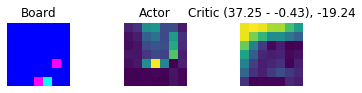

 14%|█▍        | 141/1000 [01:58<10:12,  1.40it/s]

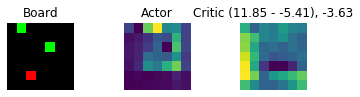

 14%|█▍        | 142/1000 [01:58<09:18,  1.54it/s]

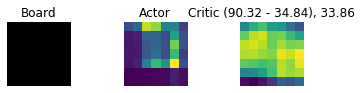

 14%|█▍        | 143/1000 [01:59<08:38,  1.65it/s]

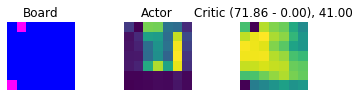

 14%|█▍        | 144/1000 [01:59<08:13,  1.74it/s]

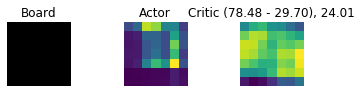

 14%|█▍        | 145/1000 [02:00<07:58,  1.79it/s]

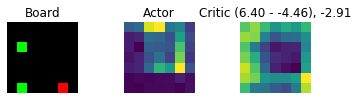

 15%|█▍        | 146/1000 [02:01<09:08,  1.56it/s]

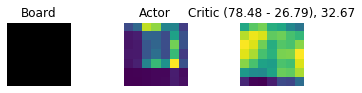

 15%|█▍        | 147/1000 [02:02<10:58,  1.30it/s]

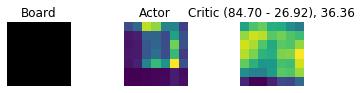

 15%|█▍        | 148/1000 [02:03<11:13,  1.27it/s]

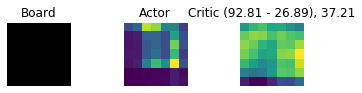

 15%|█▍        | 149/1000 [02:03<11:27,  1.24it/s]

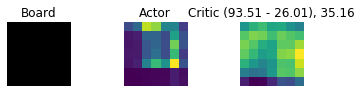

 15%|█▌        | 150/1000 [02:04<10:08,  1.40it/s]

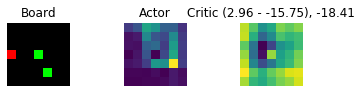

 15%|█▌        | 151/1000 [02:05<09:38,  1.47it/s]

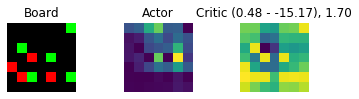

 15%|█▌        | 152/1000 [02:06<10:43,  1.32it/s]

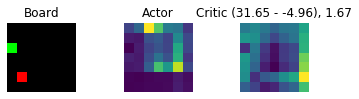

 15%|█▌        | 153/1000 [02:06<10:32,  1.34it/s]

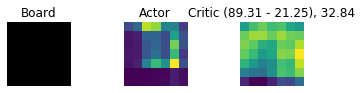

 15%|█▌        | 154/1000 [02:07<10:26,  1.35it/s]

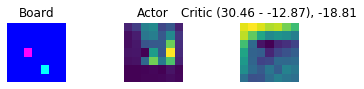

 16%|█▌        | 155/1000 [02:08<09:48,  1.43it/s]

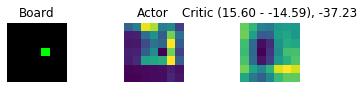

 16%|█▌        | 156/1000 [02:08<08:58,  1.57it/s]

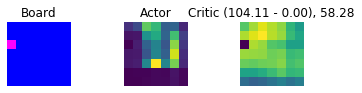

 16%|█▌        | 157/1000 [02:09<08:28,  1.66it/s]

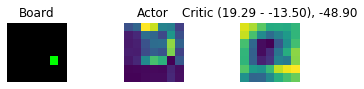

 16%|█▌        | 158/1000 [02:09<08:29,  1.65it/s]

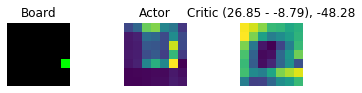

 16%|█▌        | 159/1000 [02:10<09:02,  1.55it/s]

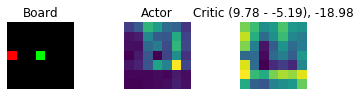

 16%|█▌        | 160/1000 [02:12<13:42,  1.02it/s]

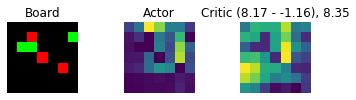

 16%|█▌        | 161/1000 [02:12<12:06,  1.15it/s]

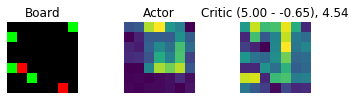

 16%|█▌        | 162/1000 [02:13<11:00,  1.27it/s]

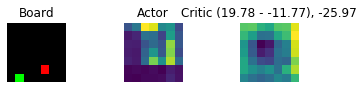

 16%|█▋        | 163/1000 [02:14<11:34,  1.20it/s]

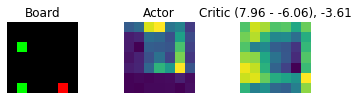

 16%|█▋        | 164/1000 [02:15<11:16,  1.24it/s]

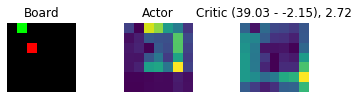

 16%|█▋        | 165/1000 [02:16<11:45,  1.18it/s]

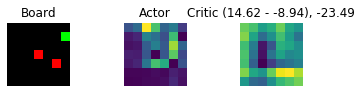

 17%|█▋        | 166/1000 [02:16<10:20,  1.34it/s]

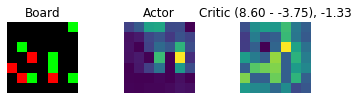

 17%|█▋        | 167/1000 [02:17<09:50,  1.41it/s]

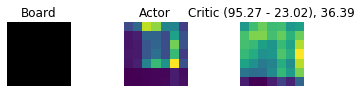

 17%|█▋        | 168/1000 [02:17<09:39,  1.43it/s]

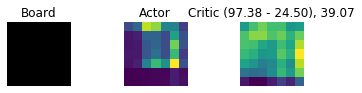

 17%|█▋        | 169/1000 [02:18<09:18,  1.49it/s]

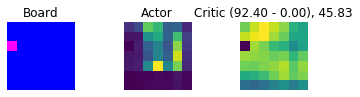

 17%|█▋        | 170/1000 [02:19<12:23,  1.12it/s]

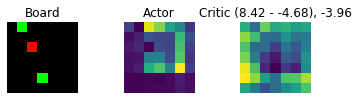

 17%|█▋        | 171/1000 [02:20<11:33,  1.20it/s]

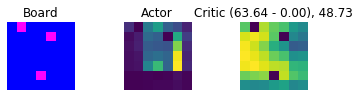

 17%|█▋        | 172/1000 [02:22<14:30,  1.05s/it]

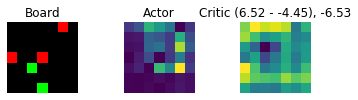

 17%|█▋        | 173/1000 [02:22<12:17,  1.12it/s]

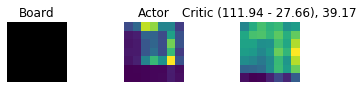

 17%|█▋        | 174/1000 [02:23<11:13,  1.23it/s]

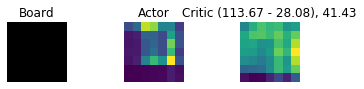

 18%|█▊        | 175/1000 [02:23<10:00,  1.37it/s]

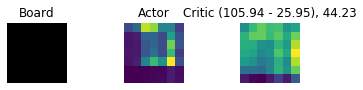

 18%|█▊        | 176/1000 [02:25<12:09,  1.13it/s]

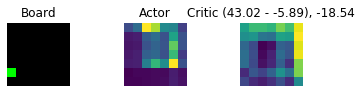

 18%|█▊        | 177/1000 [02:25<11:29,  1.19it/s]

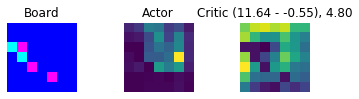

 18%|█▊        | 178/1000 [02:26<10:36,  1.29it/s]

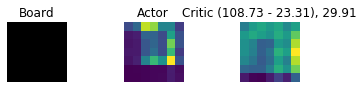

 18%|█▊        | 179/1000 [02:27<10:33,  1.30it/s]

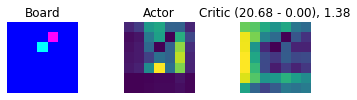

 18%|█▊        | 180/1000 [02:27<09:52,  1.38it/s]

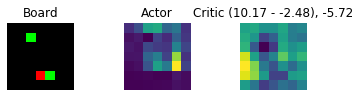

 18%|█▊        | 181/1000 [02:28<09:53,  1.38it/s]

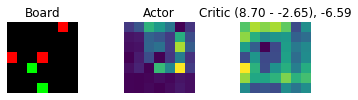

 18%|█▊        | 182/1000 [02:29<10:26,  1.30it/s]

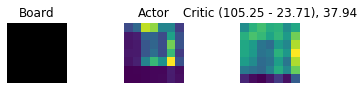

 18%|█▊        | 183/1000 [02:30<10:59,  1.24it/s]

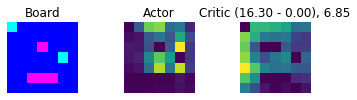

 18%|█▊        | 184/1000 [02:30<10:41,  1.27it/s]

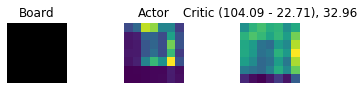

 18%|█▊        | 185/1000 [02:31<11:30,  1.18it/s]

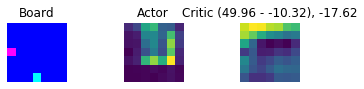

 19%|█▊        | 186/1000 [02:32<11:02,  1.23it/s]

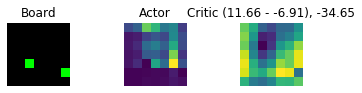

 19%|█▊        | 187/1000 [02:33<12:16,  1.10it/s]

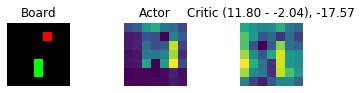

 19%|█▉        | 188/1000 [02:34<12:22,  1.09it/s]

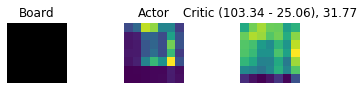

 19%|█▉        | 189/1000 [02:35<13:03,  1.04it/s]

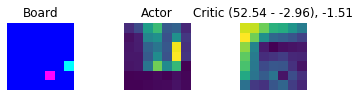

 19%|█▉        | 190/1000 [02:37<13:54,  1.03s/it]

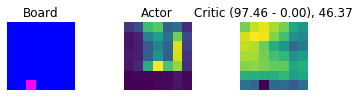

 19%|█▉        | 191/1000 [02:37<12:50,  1.05it/s]

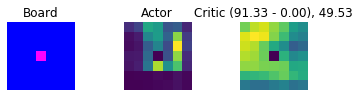

 19%|█▉        | 192/1000 [02:38<11:23,  1.18it/s]

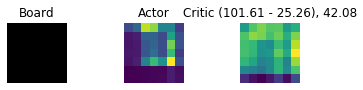

 19%|█▉        | 193/1000 [02:39<12:02,  1.12it/s]

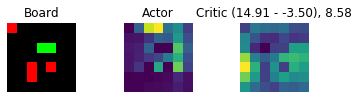

 19%|█▉        | 194/1000 [02:40<11:21,  1.18it/s]

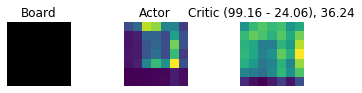

 20%|█▉        | 195/1000 [02:41<14:01,  1.05s/it]

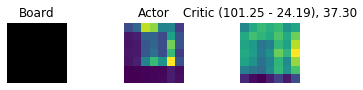

 20%|█▉        | 196/1000 [02:42<13:52,  1.03s/it]

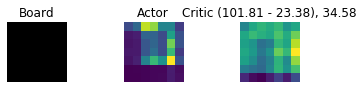

 20%|█▉        | 197/1000 [02:43<12:30,  1.07it/s]

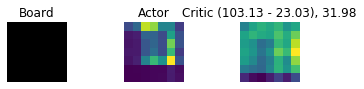

 20%|█▉        | 198/1000 [02:44<11:22,  1.18it/s]

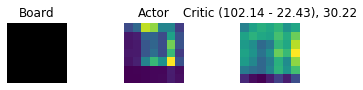

 20%|█▉        | 199/1000 [02:44<10:13,  1.31it/s]

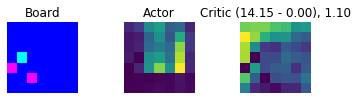

 20%|██        | 200/1000 [02:45<10:50,  1.23it/s]I0720 16:06:10.469295 4490204608 <ipython-input-35-cf0319494b27>:10] Updated opponent


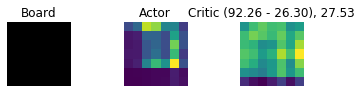

 20%|██        | 201/1000 [02:47<13:31,  1.02s/it]

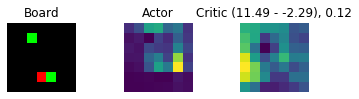

 20%|██        | 202/1000 [02:47<12:00,  1.11it/s]

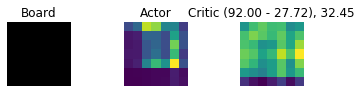

 20%|██        | 203/1000 [02:48<12:13,  1.09it/s]

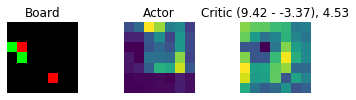

 20%|██        | 204/1000 [02:49<10:57,  1.21it/s]

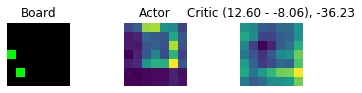

 20%|██        | 205/1000 [02:49<10:33,  1.26it/s]

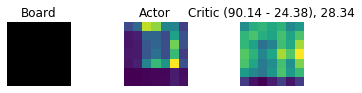

 21%|██        | 206/1000 [02:50<10:03,  1.32it/s]

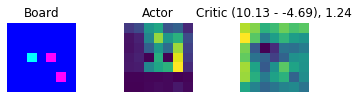

 21%|██        | 207/1000 [02:51<11:21,  1.16it/s]

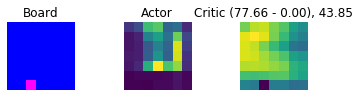

 21%|██        | 208/1000 [02:52<10:25,  1.27it/s]

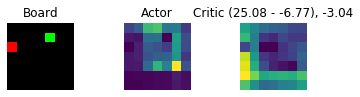

 21%|██        | 209/1000 [02:52<09:49,  1.34it/s]

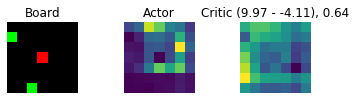

 21%|██        | 210/1000 [02:53<09:16,  1.42it/s]

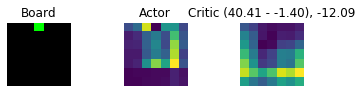

 21%|██        | 211/1000 [02:54<08:28,  1.55it/s]

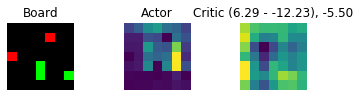

 21%|██        | 212/1000 [02:54<08:22,  1.57it/s]

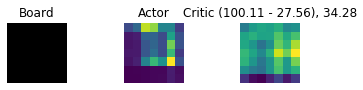

 21%|██▏       | 213/1000 [02:55<07:53,  1.66it/s]

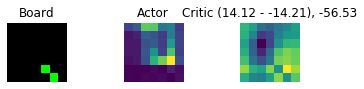

 21%|██▏       | 214/1000 [02:56<10:51,  1.21it/s]

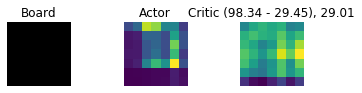

 22%|██▏       | 215/1000 [02:57<10:33,  1.24it/s]

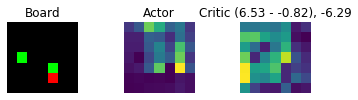

 22%|██▏       | 216/1000 [02:57<09:25,  1.39it/s]

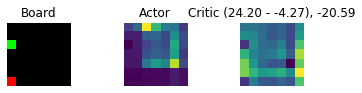

 22%|██▏       | 217/1000 [02:58<10:19,  1.26it/s]

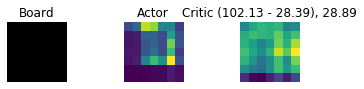

 22%|██▏       | 218/1000 [02:59<09:33,  1.36it/s]

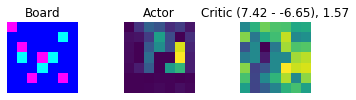

 22%|██▏       | 219/1000 [03:00<09:06,  1.43it/s]

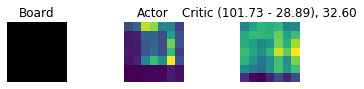

 22%|██▏       | 220/1000 [03:00<08:21,  1.55it/s]

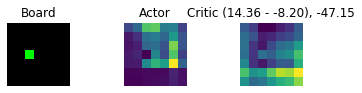

 22%|██▏       | 221/1000 [03:01<09:03,  1.43it/s]

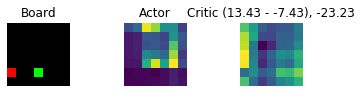

 22%|██▏       | 222/1000 [03:02<09:32,  1.36it/s]

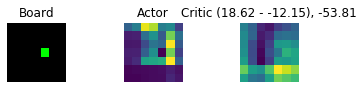

 22%|██▏       | 223/1000 [03:03<10:17,  1.26it/s]

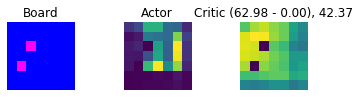

 22%|██▏       | 224/1000 [03:03<09:12,  1.40it/s]

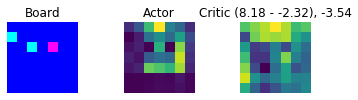

 22%|██▎       | 225/1000 [03:04<08:25,  1.53it/s]

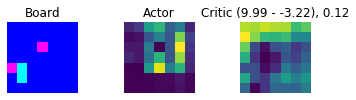

 23%|██▎       | 226/1000 [03:05<10:02,  1.29it/s]

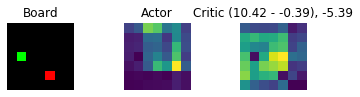

 23%|██▎       | 227/1000 [03:05<09:03,  1.42it/s]

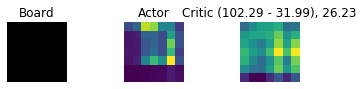

 23%|██▎       | 228/1000 [03:06<08:49,  1.46it/s]

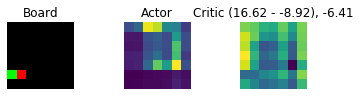

 23%|██▎       | 229/1000 [03:07<09:02,  1.42it/s]

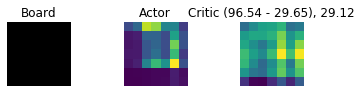

 23%|██▎       | 230/1000 [03:07<09:15,  1.39it/s]

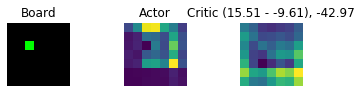

 23%|██▎       | 231/1000 [03:08<08:57,  1.43it/s]

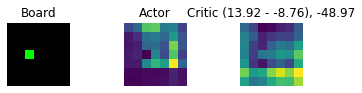

 23%|██▎       | 232/1000 [03:09<08:14,  1.55it/s]

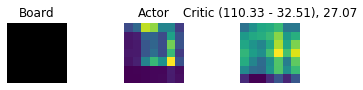

 23%|██▎       | 233/1000 [03:09<07:49,  1.63it/s]

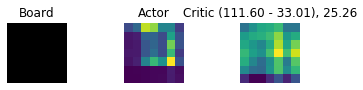

 23%|██▎       | 234/1000 [03:10<07:56,  1.61it/s]

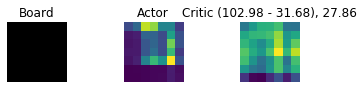

 24%|██▎       | 235/1000 [03:12<12:39,  1.01it/s]

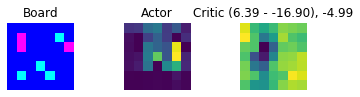

 24%|██▎       | 236/1000 [03:12<11:18,  1.13it/s]

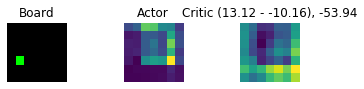

 24%|██▎       | 237/1000 [03:13<11:15,  1.13it/s]

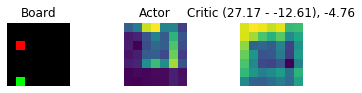

 24%|██▍       | 238/1000 [03:14<09:54,  1.28it/s]

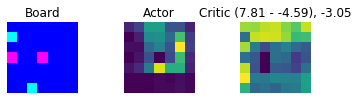

 24%|██▍       | 239/1000 [03:15<10:14,  1.24it/s]

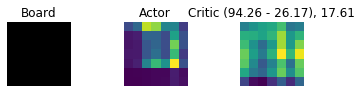

 24%|██▍       | 240/1000 [03:15<09:29,  1.33it/s]

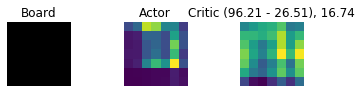

 24%|██▍       | 241/1000 [03:17<11:59,  1.06it/s]

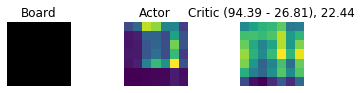

 24%|██▍       | 242/1000 [03:17<11:31,  1.10it/s]

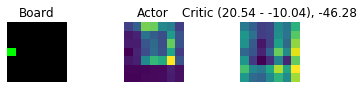

 24%|██▍       | 243/1000 [03:18<11:26,  1.10it/s]

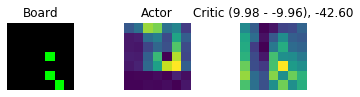

 24%|██▍       | 244/1000 [03:19<10:14,  1.23it/s]

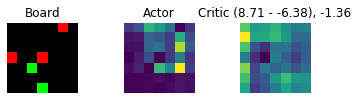

 24%|██▍       | 245/1000 [03:20<10:38,  1.18it/s]

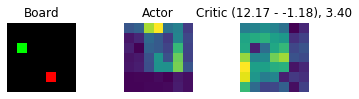

 25%|██▍       | 246/1000 [03:21<12:41,  1.01s/it]

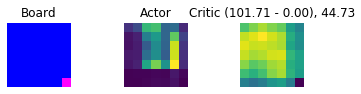

 25%|██▍       | 247/1000 [03:22<13:14,  1.06s/it]

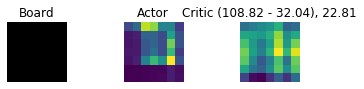

 25%|██▍       | 248/1000 [03:23<12:33,  1.00s/it]

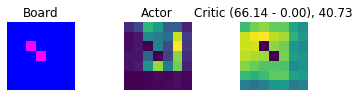

 25%|██▍       | 249/1000 [03:24<11:55,  1.05it/s]

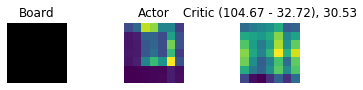

 25%|██▌       | 250/1000 [03:25<10:31,  1.19it/s]

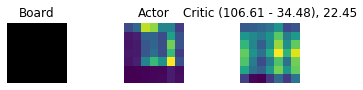

 25%|██▌       | 251/1000 [03:26<11:36,  1.08it/s]

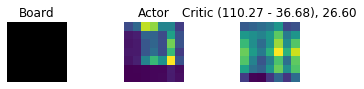

 25%|██▌       | 252/1000 [03:26<10:34,  1.18it/s]

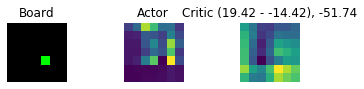

 25%|██▌       | 253/1000 [03:27<09:38,  1.29it/s]

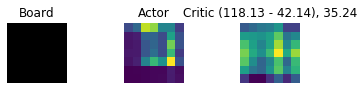

 25%|██▌       | 254/1000 [03:28<09:15,  1.34it/s]

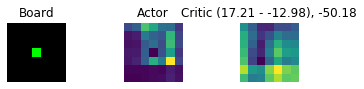

 26%|██▌       | 255/1000 [03:28<08:30,  1.46it/s]

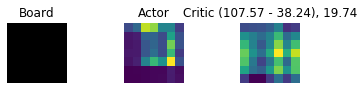

 26%|██▌       | 256/1000 [03:29<08:48,  1.41it/s]

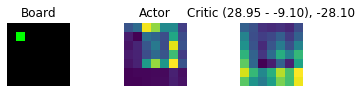

 26%|██▌       | 257/1000 [03:30<10:38,  1.16it/s]

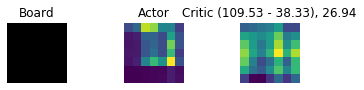

 26%|██▌       | 258/1000 [03:31<10:23,  1.19it/s]

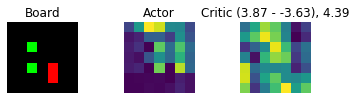

 26%|██▌       | 259/1000 [03:32<10:31,  1.17it/s]

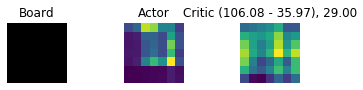

 26%|██▌       | 260/1000 [03:32<09:21,  1.32it/s]

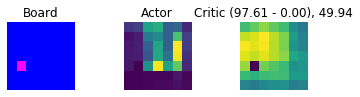

 26%|██▌       | 261/1000 [03:33<08:30,  1.45it/s]

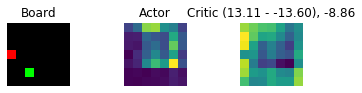

 26%|██▌       | 262/1000 [03:34<09:08,  1.34it/s]

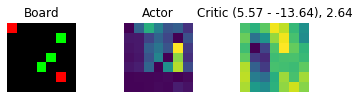

 26%|██▋       | 263/1000 [03:35<08:45,  1.40it/s]

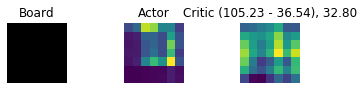

 26%|██▋       | 264/1000 [03:35<08:13,  1.49it/s]

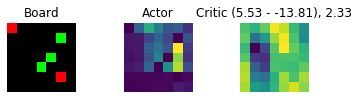

 26%|██▋       | 265/1000 [03:36<07:55,  1.55it/s]

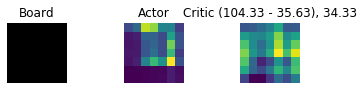

 27%|██▋       | 266/1000 [03:37<09:25,  1.30it/s]

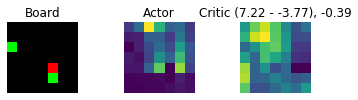

 27%|██▋       | 267/1000 [03:37<08:39,  1.41it/s]

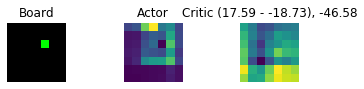

 27%|██▋       | 268/1000 [03:38<08:05,  1.51it/s]

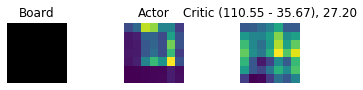

 27%|██▋       | 269/1000 [03:39<09:42,  1.26it/s]

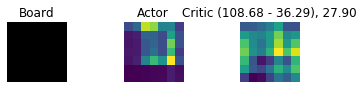

 27%|██▋       | 270/1000 [03:40<10:37,  1.15it/s]

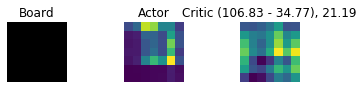

 27%|██▋       | 271/1000 [03:41<09:50,  1.23it/s]

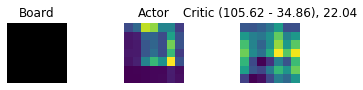

 27%|██▋       | 272/1000 [03:41<09:07,  1.33it/s]

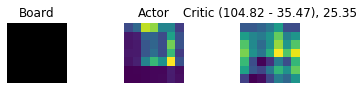

 27%|██▋       | 273/1000 [03:42<08:26,  1.44it/s]

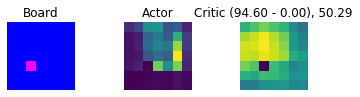

 27%|██▋       | 274/1000 [03:42<07:54,  1.53it/s]

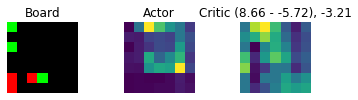

 28%|██▊       | 275/1000 [03:43<08:02,  1.50it/s]

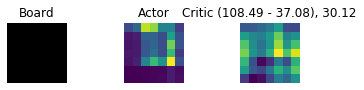

 28%|██▊       | 276/1000 [03:44<07:45,  1.55it/s]

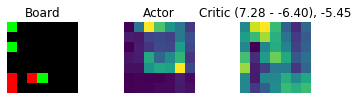

 28%|██▊       | 277/1000 [03:44<07:50,  1.54it/s]

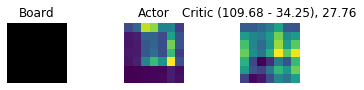

 28%|██▊       | 278/1000 [03:45<07:40,  1.57it/s]

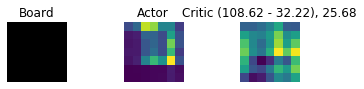

 28%|██▊       | 279/1000 [03:46<08:00,  1.50it/s]

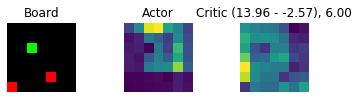

 28%|██▊       | 280/1000 [03:46<08:20,  1.44it/s]

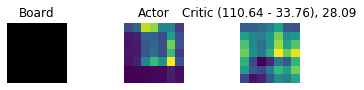

 28%|██▊       | 281/1000 [03:47<09:00,  1.33it/s]

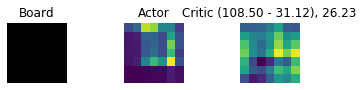

 28%|██▊       | 282/1000 [03:48<08:21,  1.43it/s]

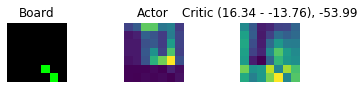

 28%|██▊       | 283/1000 [03:49<08:30,  1.40it/s]

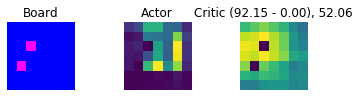

 28%|██▊       | 284/1000 [03:49<08:03,  1.48it/s]

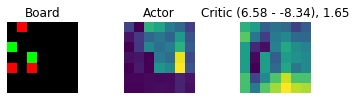

 28%|██▊       | 285/1000 [03:51<13:20,  1.12s/it]

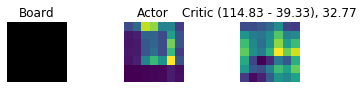

 29%|██▊       | 286/1000 [03:52<12:11,  1.02s/it]

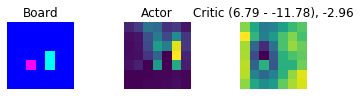

 29%|██▊       | 287/1000 [03:53<11:21,  1.05it/s]

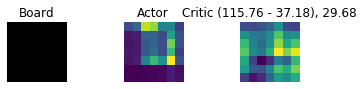

 29%|██▉       | 288/1000 [03:54<10:19,  1.15it/s]

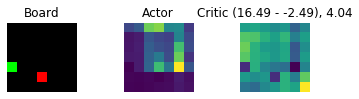

 29%|██▉       | 289/1000 [03:55<10:26,  1.13it/s]

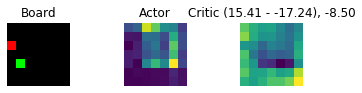

 29%|██▉       | 290/1000 [03:55<09:52,  1.20it/s]

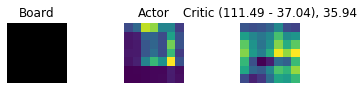

 29%|██▉       | 291/1000 [03:56<09:52,  1.20it/s]

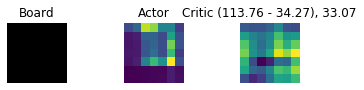

 29%|██▉       | 292/1000 [03:57<09:04,  1.30it/s]

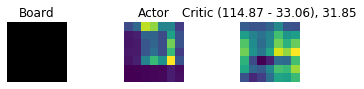

 29%|██▉       | 293/1000 [03:57<08:18,  1.42it/s]

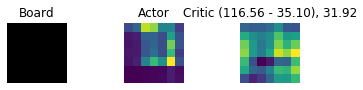

 29%|██▉       | 294/1000 [03:58<09:14,  1.27it/s]

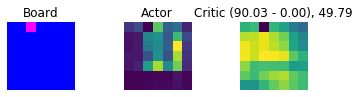

 30%|██▉       | 295/1000 [03:59<09:59,  1.18it/s]

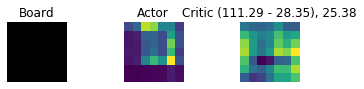

 30%|██▉       | 296/1000 [04:00<09:49,  1.19it/s]

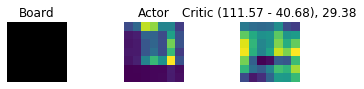

 30%|██▉       | 297/1000 [04:01<10:21,  1.13it/s]

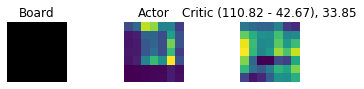

 30%|██▉       | 298/1000 [04:02<09:54,  1.18it/s]

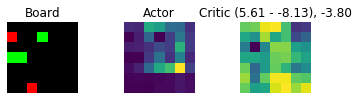

 30%|██▉       | 299/1000 [04:03<09:58,  1.17it/s]

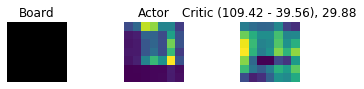

 30%|███       | 300/1000 [04:04<09:40,  1.21it/s]I0720 16:07:28.944306 4490204608 <ipython-input-35-cf0319494b27>:10] Updated opponent


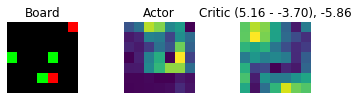

 30%|███       | 301/1000 [04:05<10:32,  1.11it/s]

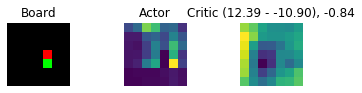

 30%|███       | 302/1000 [04:07<14:11,  1.22s/it]

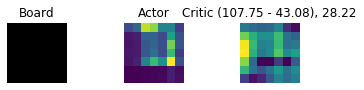

 30%|███       | 303/1000 [04:07<11:59,  1.03s/it]

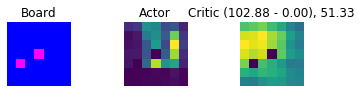

 30%|███       | 304/1000 [04:08<10:44,  1.08it/s]

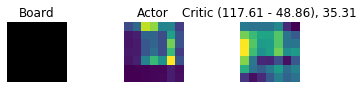

 30%|███       | 305/1000 [04:08<09:28,  1.22it/s]

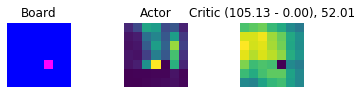

 31%|███       | 306/1000 [04:09<08:58,  1.29it/s]

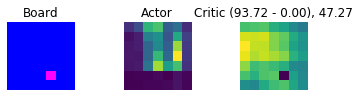

 31%|███       | 307/1000 [04:10<08:55,  1.29it/s]

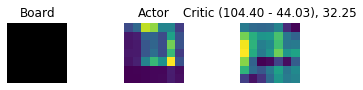

 31%|███       | 308/1000 [04:11<10:13,  1.13it/s]

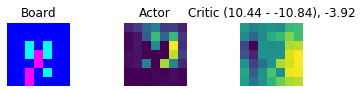

 31%|███       | 309/1000 [04:12<09:06,  1.26it/s]

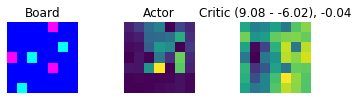

 31%|███       | 310/1000 [04:12<08:18,  1.38it/s]

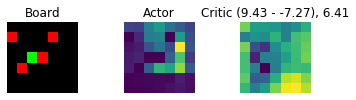

 31%|███       | 311/1000 [04:13<08:05,  1.42it/s]

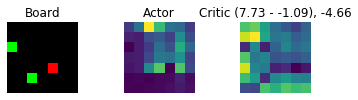

 31%|███       | 312/1000 [04:14<08:47,  1.30it/s]

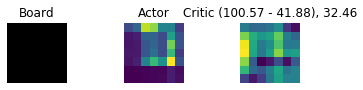

 31%|███▏      | 313/1000 [04:14<08:03,  1.42it/s]

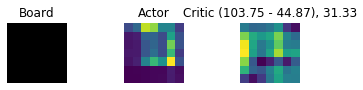

 31%|███▏      | 314/1000 [04:15<08:20,  1.37it/s]

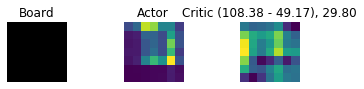

 32%|███▏      | 315/1000 [04:16<08:51,  1.29it/s]

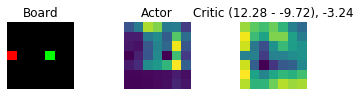

 32%|███▏      | 316/1000 [04:16<08:09,  1.40it/s]

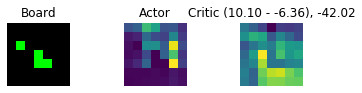

 32%|███▏      | 317/1000 [04:17<08:26,  1.35it/s]

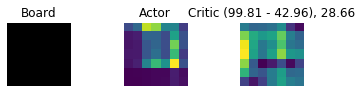

 32%|███▏      | 318/1000 [04:18<08:00,  1.42it/s]

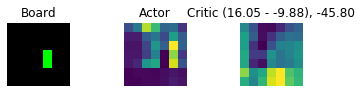

 32%|███▏      | 319/1000 [04:19<08:46,  1.29it/s]

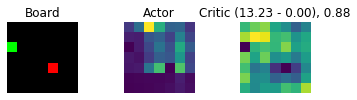

 32%|███▏      | 320/1000 [04:20<08:28,  1.34it/s]

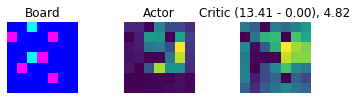

 32%|███▏      | 321/1000 [04:20<07:57,  1.42it/s]

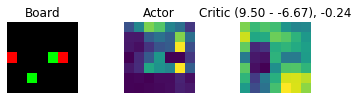

 32%|███▏      | 322/1000 [04:21<07:36,  1.48it/s]

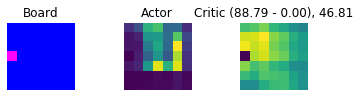

 32%|███▏      | 323/1000 [04:22<08:20,  1.35it/s]

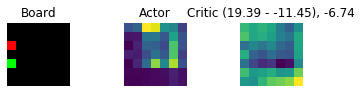

 32%|███▏      | 324/1000 [04:23<09:13,  1.22it/s]

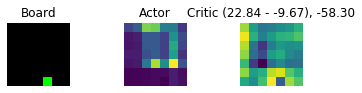

 32%|███▎      | 325/1000 [04:24<11:45,  1.05s/it]

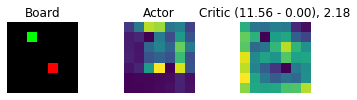

 33%|███▎      | 326/1000 [04:25<11:09,  1.01it/s]

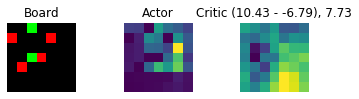

 33%|███▎      | 327/1000 [04:26<09:55,  1.13it/s]

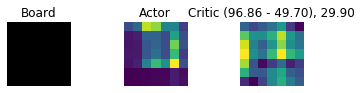

 33%|███▎      | 328/1000 [04:27<09:51,  1.14it/s]

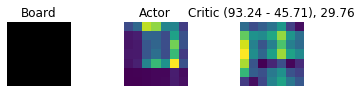

 33%|███▎      | 329/1000 [04:28<11:02,  1.01it/s]

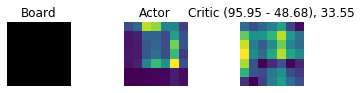

 33%|███▎      | 330/1000 [04:29<12:08,  1.09s/it]

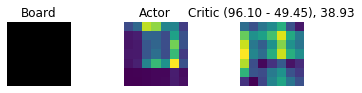

 33%|███▎      | 331/1000 [04:31<14:18,  1.28s/it]

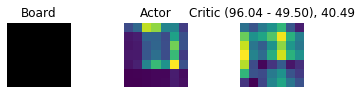

 33%|███▎      | 332/1000 [04:32<12:53,  1.16s/it]

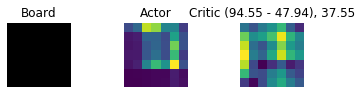

 33%|███▎      | 333/1000 [04:32<11:02,  1.01it/s]

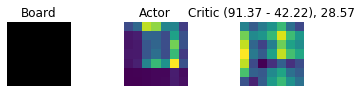

 33%|███▎      | 334/1000 [04:33<10:05,  1.10it/s]

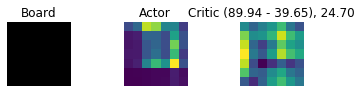

 34%|███▎      | 335/1000 [04:34<09:19,  1.19it/s]

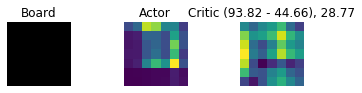

 34%|███▎      | 336/1000 [04:34<08:50,  1.25it/s]

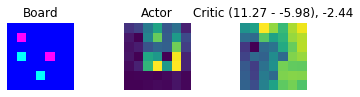

 34%|███▎      | 337/1000 [04:35<08:25,  1.31it/s]

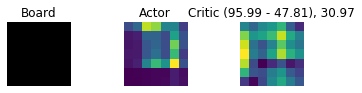

 34%|███▍      | 338/1000 [04:36<07:54,  1.40it/s]

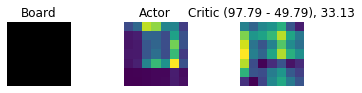

 34%|███▍      | 339/1000 [04:36<07:50,  1.40it/s]

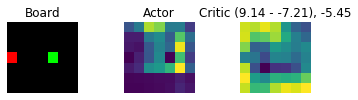

 34%|███▍      | 340/1000 [04:37<07:26,  1.48it/s]

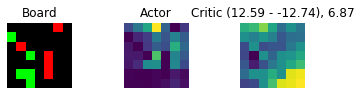

 34%|███▍      | 341/1000 [04:38<08:28,  1.30it/s]

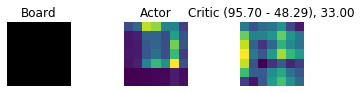

 34%|███▍      | 342/1000 [04:39<08:10,  1.34it/s]

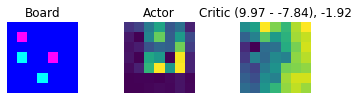

 34%|███▍      | 343/1000 [04:41<13:43,  1.25s/it]

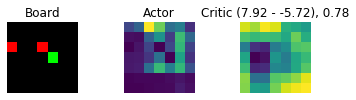

 34%|███▍      | 344/1000 [04:42<12:31,  1.15s/it]

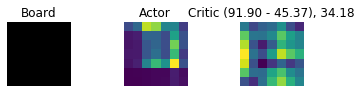

 34%|███▍      | 345/1000 [04:43<11:47,  1.08s/it]

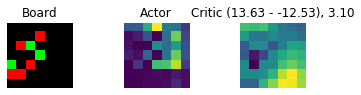

 35%|███▍      | 346/1000 [04:44<10:27,  1.04it/s]

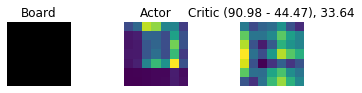

 35%|███▍      | 347/1000 [04:44<09:19,  1.17it/s]

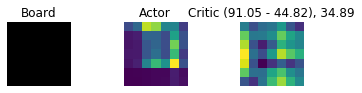

 35%|███▍      | 348/1000 [04:45<09:13,  1.18it/s]

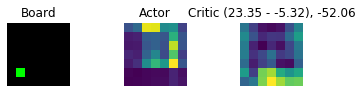

 35%|███▍      | 349/1000 [04:46<09:25,  1.15it/s]

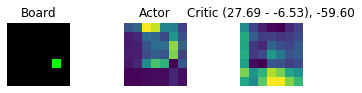

 35%|███▌      | 350/1000 [04:47<08:51,  1.22it/s]

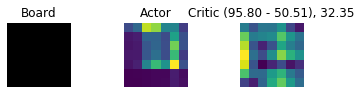

 35%|███▌      | 351/1000 [04:47<08:44,  1.24it/s]

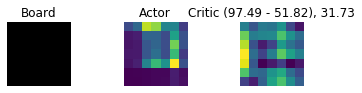

 35%|███▌      | 352/1000 [04:49<09:29,  1.14it/s]

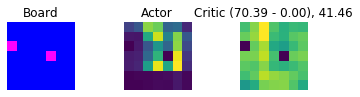

 35%|███▌      | 353/1000 [04:49<09:13,  1.17it/s]

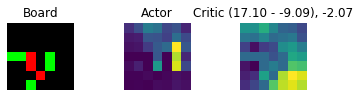

 35%|███▌      | 354/1000 [04:50<08:29,  1.27it/s]

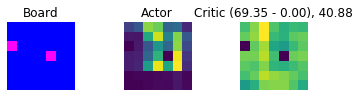

 36%|███▌      | 355/1000 [04:51<07:57,  1.35it/s]

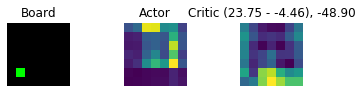

 36%|███▌      | 356/1000 [04:51<07:50,  1.37it/s]

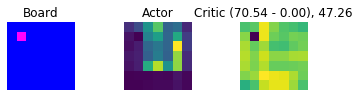

 36%|███▌      | 357/1000 [04:52<07:59,  1.34it/s]

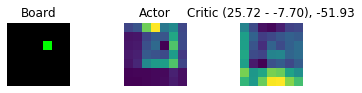

 36%|███▌      | 358/1000 [04:53<08:04,  1.33it/s]

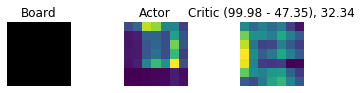

 36%|███▌      | 359/1000 [04:53<07:41,  1.39it/s]

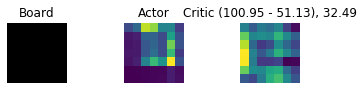

 36%|███▌      | 360/1000 [04:55<10:31,  1.01it/s]

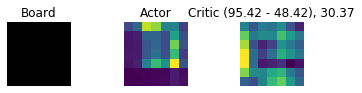

 36%|███▌      | 361/1000 [04:56<11:31,  1.08s/it]

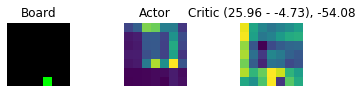

 36%|███▌      | 362/1000 [04:57<10:26,  1.02it/s]

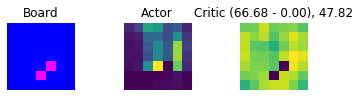

 36%|███▋      | 363/1000 [04:58<09:18,  1.14it/s]

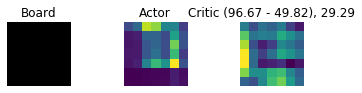

 36%|███▋      | 364/1000 [04:59<08:56,  1.18it/s]

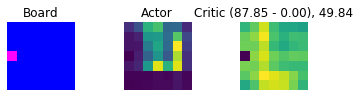

 36%|███▋      | 365/1000 [04:59<08:35,  1.23it/s]

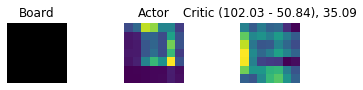

 37%|███▋      | 366/1000 [05:00<08:16,  1.28it/s]

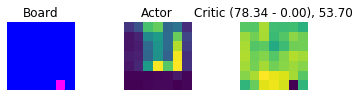

 37%|███▋      | 367/1000 [05:01<08:00,  1.32it/s]

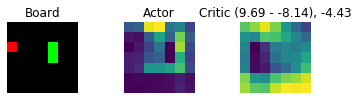

 37%|███▋      | 368/1000 [05:01<07:49,  1.35it/s]

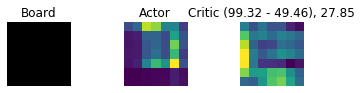

 37%|███▋      | 369/1000 [05:02<07:33,  1.39it/s]

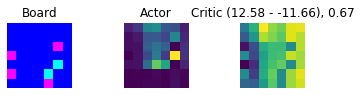

 37%|███▋      | 370/1000 [05:03<08:36,  1.22it/s]

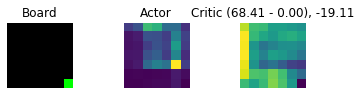

 37%|███▋      | 371/1000 [05:04<08:07,  1.29it/s]

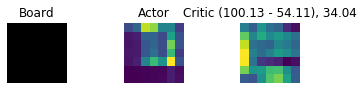

 37%|███▋      | 372/1000 [05:05<08:01,  1.31it/s]

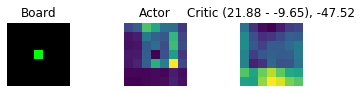

 37%|███▋      | 373/1000 [05:05<07:48,  1.34it/s]

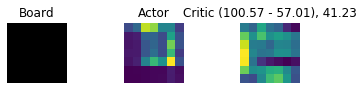

 37%|███▋      | 374/1000 [05:06<07:47,  1.34it/s]

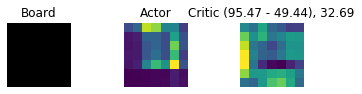

 38%|███▊      | 375/1000 [05:07<08:06,  1.28it/s]

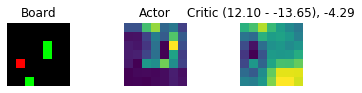

 38%|███▊      | 376/1000 [05:08<09:00,  1.16it/s]

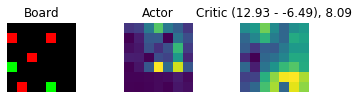

 38%|███▊      | 377/1000 [05:09<09:18,  1.12it/s]

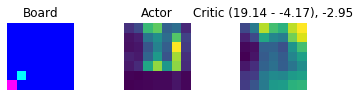

 38%|███▊      | 378/1000 [05:10<08:48,  1.18it/s]

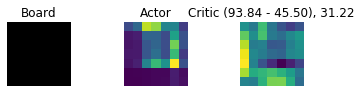

 38%|███▊      | 379/1000 [05:11<09:56,  1.04it/s]

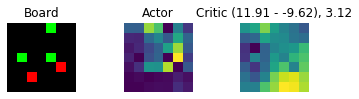

 38%|███▊      | 380/1000 [05:12<08:58,  1.15it/s]

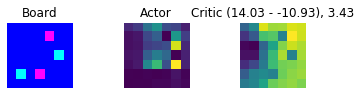

 38%|███▊      | 381/1000 [05:12<08:58,  1.15it/s]

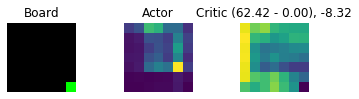

 38%|███▊      | 382/1000 [05:13<08:37,  1.19it/s]

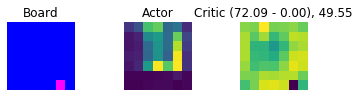

 38%|███▊      | 383/1000 [05:14<08:18,  1.24it/s]

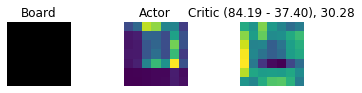

 38%|███▊      | 384/1000 [05:15<07:45,  1.32it/s]

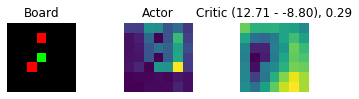

 38%|███▊      | 385/1000 [05:15<07:57,  1.29it/s]

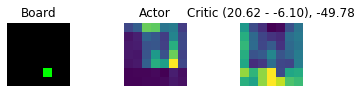

 39%|███▊      | 386/1000 [05:16<07:35,  1.35it/s]

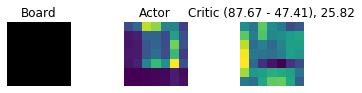

 39%|███▊      | 387/1000 [05:17<07:43,  1.32it/s]

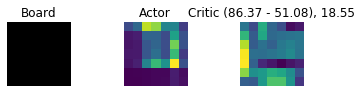

 39%|███▉      | 388/1000 [05:18<10:10,  1.00it/s]

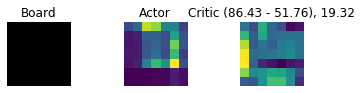

 39%|███▉      | 389/1000 [05:19<09:03,  1.12it/s]

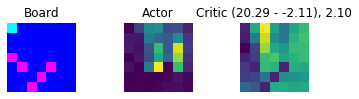

 39%|███▉      | 390/1000 [05:20<08:30,  1.19it/s]

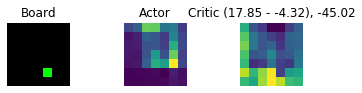

 39%|███▉      | 391/1000 [05:20<08:12,  1.24it/s]

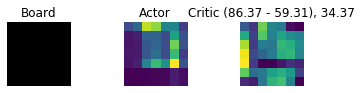

 39%|███▉      | 392/1000 [05:22<09:06,  1.11it/s]

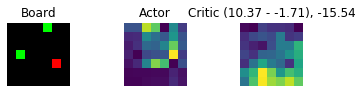

 39%|███▉      | 393/1000 [05:22<08:19,  1.21it/s]

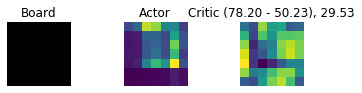

 39%|███▉      | 394/1000 [05:23<08:50,  1.14it/s]

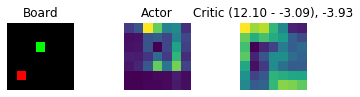

 40%|███▉      | 395/1000 [05:24<08:28,  1.19it/s]

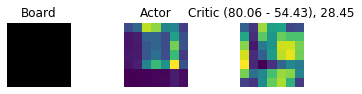

 40%|███▉      | 396/1000 [05:25<08:09,  1.23it/s]

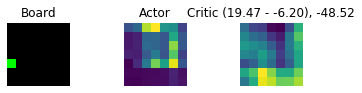

 40%|███▉      | 397/1000 [05:25<07:55,  1.27it/s]

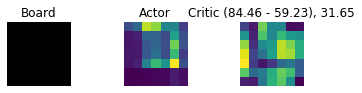

 40%|███▉      | 398/1000 [05:26<07:47,  1.29it/s]

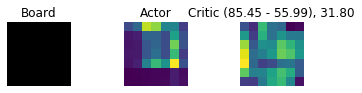

 40%|███▉      | 399/1000 [05:27<07:56,  1.26it/s]

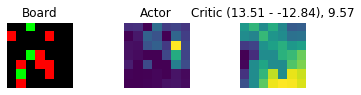

 40%|████      | 400/1000 [05:28<08:07,  1.23it/s]I0720 16:08:53.401271 4490204608 <ipython-input-35-cf0319494b27>:10] Updated opponent


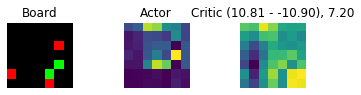

 40%|████      | 401/1000 [05:29<09:19,  1.07it/s]

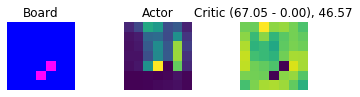

 40%|████      | 402/1000 [05:30<09:27,  1.05it/s]

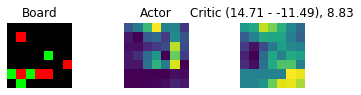

 40%|████      | 403/1000 [05:31<08:50,  1.12it/s]

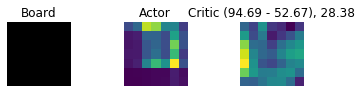

 40%|████      | 404/1000 [05:32<08:22,  1.19it/s]

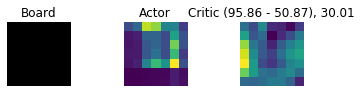

 40%|████      | 405/1000 [05:32<08:24,  1.18it/s]

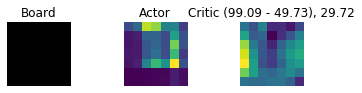

 41%|████      | 406/1000 [05:33<08:56,  1.11it/s]

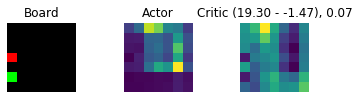

 41%|████      | 407/1000 [05:34<08:31,  1.16it/s]

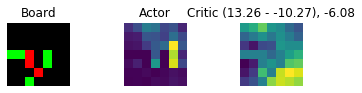

 41%|████      | 408/1000 [05:35<08:32,  1.16it/s]

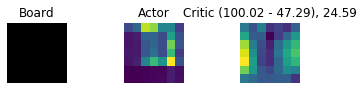

 41%|████      | 409/1000 [05:36<09:26,  1.04it/s]

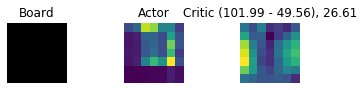

 41%|████      | 410/1000 [05:37<08:57,  1.10it/s]

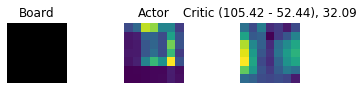

 41%|████      | 411/1000 [05:38<09:10,  1.07it/s]

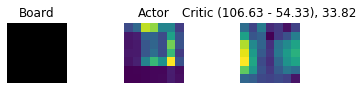

 41%|████      | 412/1000 [05:39<08:51,  1.11it/s]

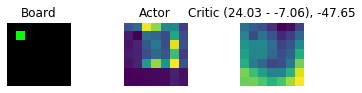

 41%|████▏     | 413/1000 [05:42<14:19,  1.47s/it]

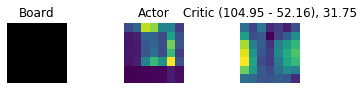

 41%|████▏     | 414/1000 [05:42<12:23,  1.27s/it]

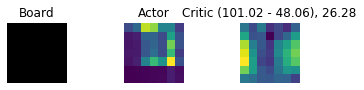

 42%|████▏     | 415/1000 [05:43<11:19,  1.16s/it]

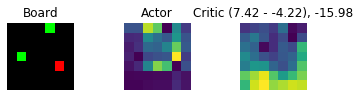

 42%|████▏     | 416/1000 [05:45<11:30,  1.18s/it]

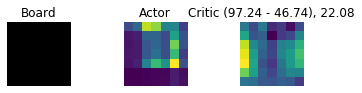

 42%|████▏     | 417/1000 [05:45<10:16,  1.06s/it]

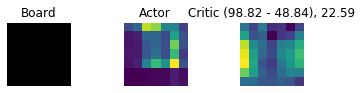

 42%|████▏     | 418/1000 [05:46<09:04,  1.07it/s]

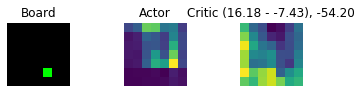

 42%|████▏     | 419/1000 [05:47<08:49,  1.10it/s]

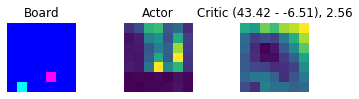

 42%|████▏     | 420/1000 [05:48<08:03,  1.20it/s]

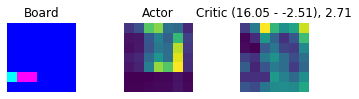

 42%|████▏     | 421/1000 [05:48<08:10,  1.18it/s]

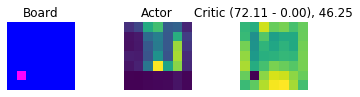

 42%|████▏     | 422/1000 [05:49<07:36,  1.27it/s]

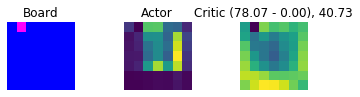

 42%|████▏     | 423/1000 [05:50<07:12,  1.33it/s]

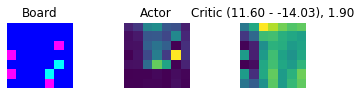

 42%|████▏     | 424/1000 [05:50<06:55,  1.39it/s]

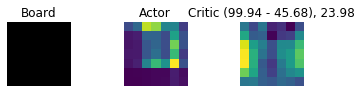

 42%|████▎     | 425/1000 [05:52<09:36,  1.00s/it]

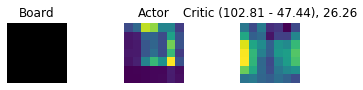

 43%|████▎     | 426/1000 [05:53<08:40,  1.10it/s]

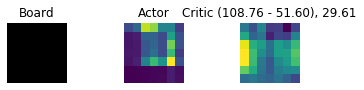

 43%|████▎     | 427/1000 [05:54<08:38,  1.11it/s]

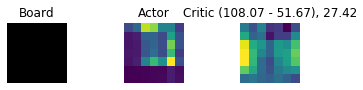

 43%|████▎     | 428/1000 [05:54<08:16,  1.15it/s]

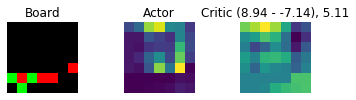

 43%|████▎     | 429/1000 [05:55<07:45,  1.23it/s]

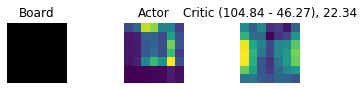

 43%|████▎     | 430/1000 [05:56<07:42,  1.23it/s]

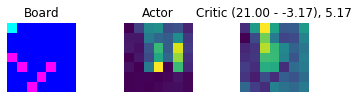

 43%|████▎     | 431/1000 [05:57<07:37,  1.24it/s]

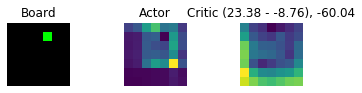

 43%|████▎     | 432/1000 [05:57<07:15,  1.30it/s]

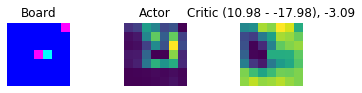

 43%|████▎     | 433/1000 [05:58<07:18,  1.29it/s]

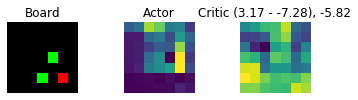

 43%|████▎     | 434/1000 [06:00<09:31,  1.01s/it]

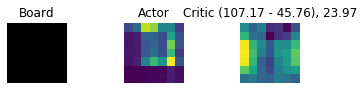

 44%|████▎     | 435/1000 [06:01<08:54,  1.06it/s]

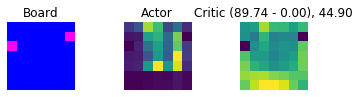

 44%|████▎     | 436/1000 [06:01<08:26,  1.11it/s]

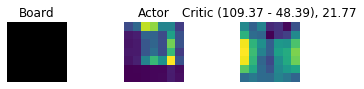

 44%|████▎     | 437/1000 [06:02<07:50,  1.20it/s]

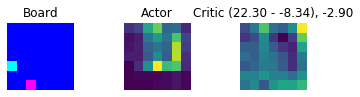

 44%|████▍     | 438/1000 [06:03<08:48,  1.06it/s]

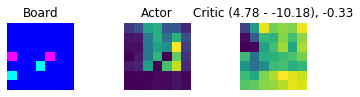

 44%|████▍     | 439/1000 [06:04<08:41,  1.08it/s]

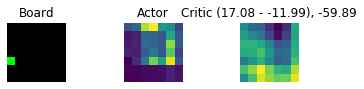

 44%|████▍     | 440/1000 [06:05<08:16,  1.13it/s]

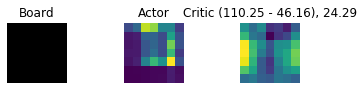

 44%|████▍     | 441/1000 [06:06<08:03,  1.16it/s]

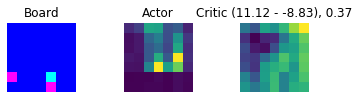

 44%|████▍     | 442/1000 [06:06<07:34,  1.23it/s]

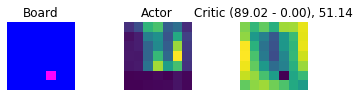

 44%|████▍     | 443/1000 [06:08<09:14,  1.00it/s]

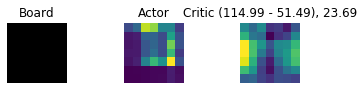

 44%|████▍     | 444/1000 [06:09<08:25,  1.10it/s]

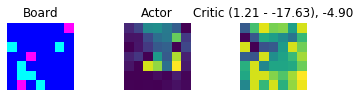

 44%|████▍     | 445/1000 [06:10<08:48,  1.05it/s]

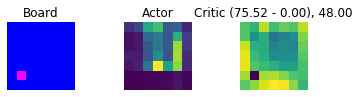

 45%|████▍     | 446/1000 [06:10<08:02,  1.15it/s]

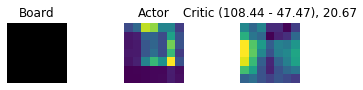

 45%|████▍     | 447/1000 [06:11<07:47,  1.18it/s]

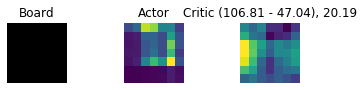

 45%|████▍     | 448/1000 [06:12<07:38,  1.20it/s]

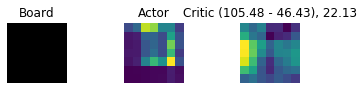

 45%|████▍     | 449/1000 [06:13<08:26,  1.09it/s]

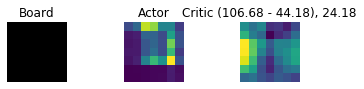

 45%|████▌     | 450/1000 [06:14<08:24,  1.09it/s]

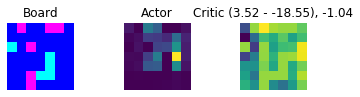

 45%|████▌     | 451/1000 [06:15<07:45,  1.18it/s]

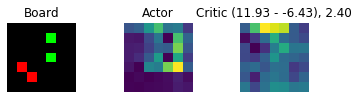

 45%|████▌     | 452/1000 [06:15<07:36,  1.20it/s]

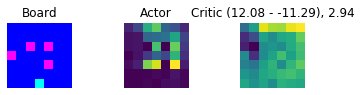

 45%|████▌     | 453/1000 [06:16<07:14,  1.26it/s]

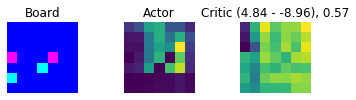

 45%|████▌     | 454/1000 [06:18<09:24,  1.03s/it]

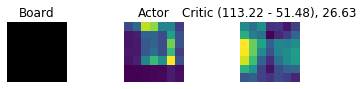

 46%|████▌     | 455/1000 [06:18<08:32,  1.06it/s]

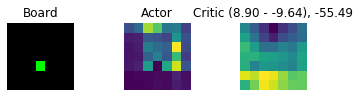

 46%|████▌     | 456/1000 [06:19<08:32,  1.06it/s]

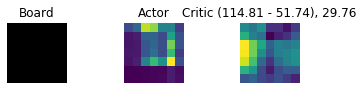

 46%|████▌     | 457/1000 [06:20<07:55,  1.14it/s]

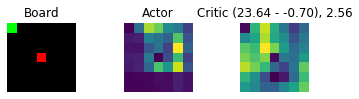

 46%|████▌     | 458/1000 [06:21<07:26,  1.21it/s]

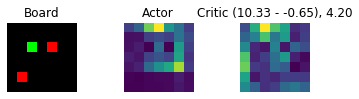

 46%|████▌     | 459/1000 [06:22<07:43,  1.17it/s]

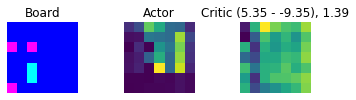

 46%|████▌     | 460/1000 [06:22<07:32,  1.19it/s]

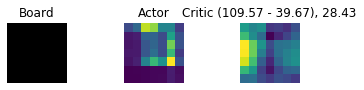

 46%|████▌     | 461/1000 [06:23<07:08,  1.26it/s]

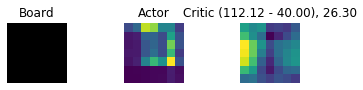

 46%|████▌     | 462/1000 [06:24<07:07,  1.26it/s]

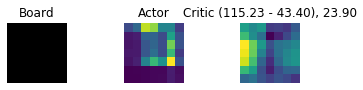

 46%|████▋     | 463/1000 [06:25<07:05,  1.26it/s]

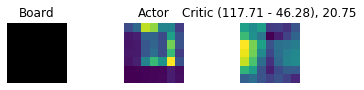

 46%|████▋     | 464/1000 [06:26<07:41,  1.16it/s]

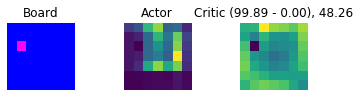

 46%|████▋     | 465/1000 [06:26<07:16,  1.23it/s]

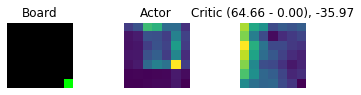

 47%|████▋     | 466/1000 [06:27<07:32,  1.18it/s]

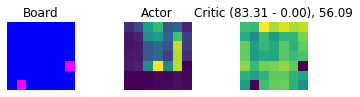

 47%|████▋     | 467/1000 [06:28<07:23,  1.20it/s]

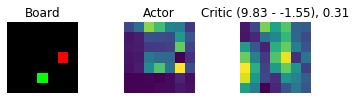

 47%|████▋     | 468/1000 [06:29<07:40,  1.16it/s]

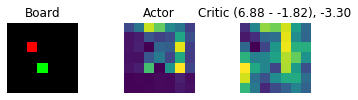

 47%|████▋     | 469/1000 [06:30<08:11,  1.08it/s]

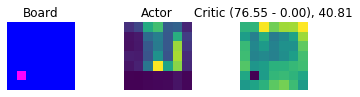

 47%|████▋     | 470/1000 [06:31<08:12,  1.08it/s]

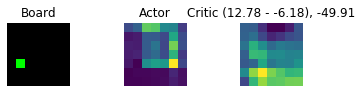

 47%|████▋     | 471/1000 [06:32<07:58,  1.11it/s]

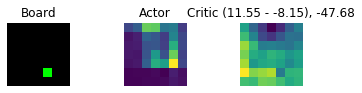

 47%|████▋     | 472/1000 [06:33<08:27,  1.04it/s]

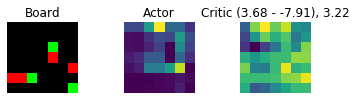

 47%|████▋     | 473/1000 [06:34<07:47,  1.13it/s]

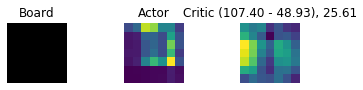

 47%|████▋     | 474/1000 [06:35<07:59,  1.10it/s]

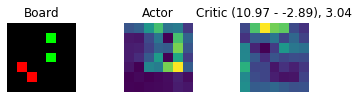

 48%|████▊     | 475/1000 [06:36<09:22,  1.07s/it]

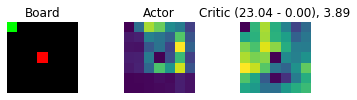

 48%|████▊     | 476/1000 [06:37<08:24,  1.04it/s]

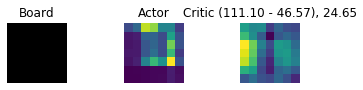

 48%|████▊     | 477/1000 [06:38<07:45,  1.12it/s]

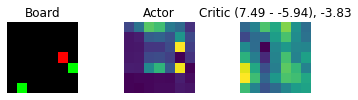

 48%|████▊     | 478/1000 [06:39<08:47,  1.01s/it]

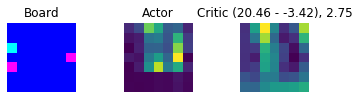

 48%|████▊     | 479/1000 [06:40<08:15,  1.05it/s]

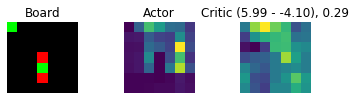

 48%|████▊     | 480/1000 [06:41<07:54,  1.10it/s]

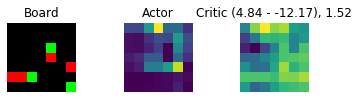

 48%|████▊     | 481/1000 [06:41<07:21,  1.18it/s]

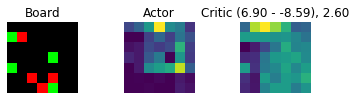

 48%|████▊     | 482/1000 [06:42<07:04,  1.22it/s]

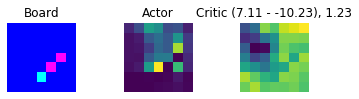

 48%|████▊     | 483/1000 [06:43<07:04,  1.22it/s]

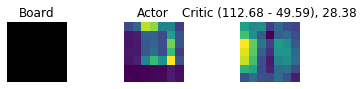

 48%|████▊     | 484/1000 [06:44<07:25,  1.16it/s]

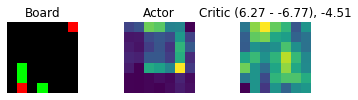

 48%|████▊     | 485/1000 [06:45<07:21,  1.17it/s]

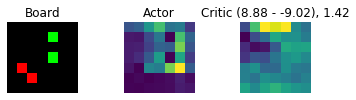

 49%|████▊     | 486/1000 [06:46<07:35,  1.13it/s]

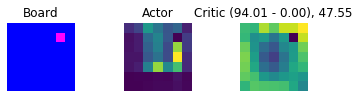

 49%|████▊     | 487/1000 [06:46<07:11,  1.19it/s]

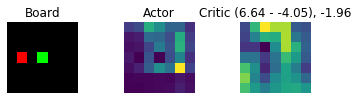

 49%|████▉     | 488/1000 [06:48<08:15,  1.03it/s]

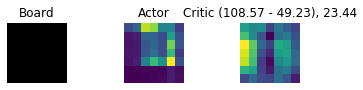

 49%|████▉     | 489/1000 [06:48<07:39,  1.11it/s]

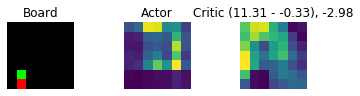

 49%|████▉     | 490/1000 [06:49<07:28,  1.14it/s]

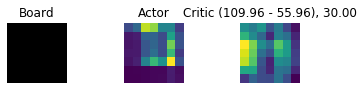

 49%|████▉     | 491/1000 [06:50<07:41,  1.10it/s]

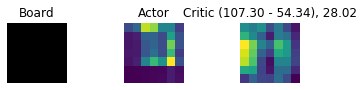

 49%|████▉     | 492/1000 [06:51<07:34,  1.12it/s]

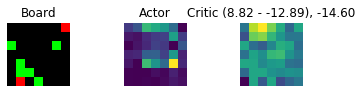

 49%|████▉     | 493/1000 [06:52<07:07,  1.19it/s]

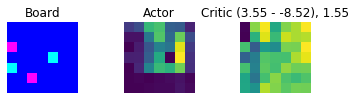

 49%|████▉     | 494/1000 [06:53<07:09,  1.18it/s]

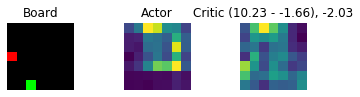

 50%|████▉     | 495/1000 [06:53<07:10,  1.17it/s]

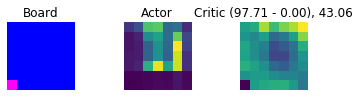

 50%|████▉     | 496/1000 [06:54<07:25,  1.13it/s]

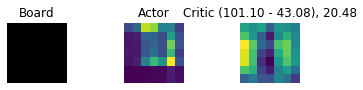

 50%|████▉     | 497/1000 [06:55<07:20,  1.14it/s]

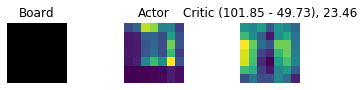

 50%|████▉     | 498/1000 [06:59<13:43,  1.64s/it]

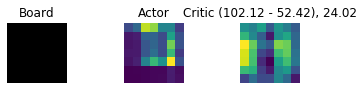

 50%|████▉     | 499/1000 [06:59<11:28,  1.37s/it]

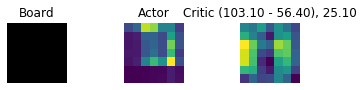

 50%|█████     | 500/1000 [07:00<09:45,  1.17s/it]I0720 16:10:25.734913 4490204608 <ipython-input-35-cf0319494b27>:10] Updated opponent


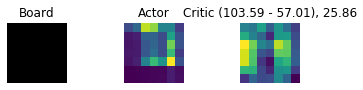

 50%|█████     | 501/1000 [07:01<10:02,  1.21s/it]

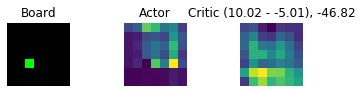

 50%|█████     | 502/1000 [07:03<10:10,  1.23s/it]

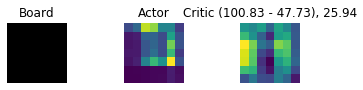

 50%|█████     | 503/1000 [07:04<09:52,  1.19s/it]

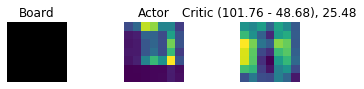

 50%|█████     | 504/1000 [07:05<08:40,  1.05s/it]

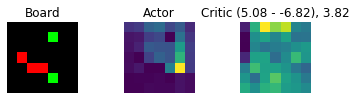

 50%|█████     | 505/1000 [07:05<08:18,  1.01s/it]

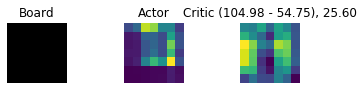

 51%|█████     | 506/1000 [07:06<07:50,  1.05it/s]

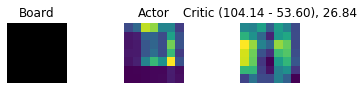

 51%|█████     | 507/1000 [07:07<07:43,  1.06it/s]

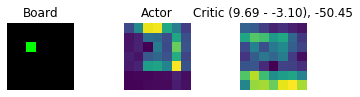

 51%|█████     | 508/1000 [07:08<07:57,  1.03it/s]

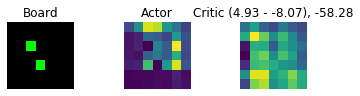

 51%|█████     | 509/1000 [07:09<07:24,  1.10it/s]

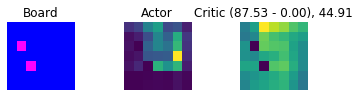

 51%|█████     | 510/1000 [07:10<07:03,  1.16it/s]

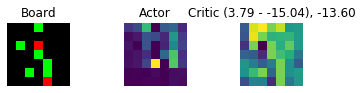

 51%|█████     | 511/1000 [07:11<07:48,  1.04it/s]

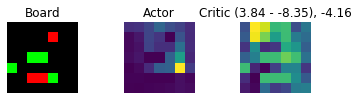

 51%|█████     | 512/1000 [07:12<07:11,  1.13it/s]

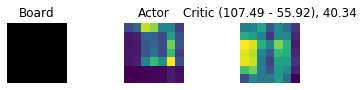

 51%|█████▏    | 513/1000 [07:12<07:08,  1.14it/s]

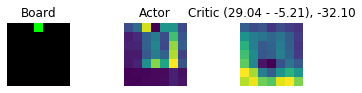

 51%|█████▏    | 514/1000 [07:14<07:25,  1.09it/s]

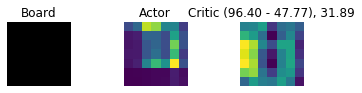

 52%|█████▏    | 515/1000 [07:15<08:15,  1.02s/it]

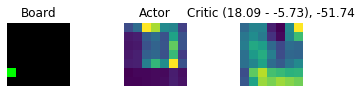

 52%|█████▏    | 516/1000 [07:16<08:46,  1.09s/it]

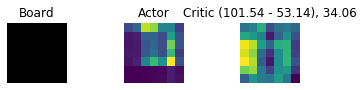

 52%|█████▏    | 517/1000 [07:17<07:58,  1.01it/s]

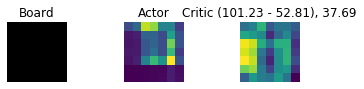

 52%|█████▏    | 518/1000 [07:18<07:55,  1.01it/s]

In [ ]:
for episode in tqdm(range(NUM_EPISODES)):
    # Reset all metrics
    for metric in actor_metrics.values():
        metric.reset_states()
    for metric in critic_metrics.values():
        metric.reset_states()
    
    if episode % OPPONENT_UPDATE == 0:
        opponent = copy_actor_critic(actor, 'actor')
        logging.info("Updated opponent")
        
    if episode % TARGET_UPDATE == 0:
        target_critic = copy_actor_critic(critic, 'critic')

    num_turns, rewards = train(episode)
    
    # Plot samples of states and actor, critic heatmaps
    num_samples = 1
    states, _, _, _,_ = get_batch_obs(num_samples)
    board_prob_distrs, pass_probs = actor([states, 1-states[:,:,:,2]])
    board_val_distrs, pass_vals = critic([states, 1-states[:,:,:,2]])
    plt.figure(figsize=(5,1.5))
    for i in range(num_samples):
        plt.subplot(num_samples,3,3*i+1+0)
        plt.axis('off')
        plt.title('Board')
        plt.imshow(states[i][:,:,[0,1,3]].astype(np.float))
        plt.subplot(num_samples,3,3*i+1+1)
        plt.axis('off')
        plt.title('Actor\nL{:.2f} H{:.2f} P{:.2f}'
                  .format(np.min(board_prob_distrs), 
                          np.max(board_prob_distrs),pass_probs[i][0]))
        plt.imshow(board_prob_distrs[i])
        plt.subplot(num_samples,3,3*i+1+2)
        plt.axis('off')
        plt.title('Critic\nL{:.2f} H{:.2f} P{:.2f}'
                  .format(np.min(board_val_distrs), 
                          np.max(board_val_distrs), pass_vals[i][0]))
        plt.imshow(board_val_distrs[i])
        
    plt.tight_layout()
    plt.show()
    
    # log results
    with summary_writers['main'].as_default():
        tf.summary.scalar('last rewards', rewards[-1], step=episode)
        tf.summary.scalar('rewards sum', sum(rewards), step=episode)
        tf.summary.scalar('number of moves', num_turns, step=episode)
        tf.summary.scalar('critic loss', critic_metrics['loss'].result(), step=episode)
        tf.summary.scalar('actor loss', actor_metrics['loss'].result(), step=episode)
        tf.summary.scalar('epsilon', EPSILON, step=episode)
        

In [ ]:
actor.save_weights('tmp/actor.h5')
critic.save_weights('tmp/critic.h5')

# Evaluate

Test against a pretrained AI

In [ ]:
# TODO

Play against our AI

In [ ]:
go_env = gym.make('gym_go:go-v0', size='S')

state = go_env.reset()

done = False
while not done:
    go_env.render()
    
    # Actor's move
    action = get_action(actor, state, 0)
    
    state, reward, done, info = go_env.step(action)
    
    go_env.render()
    
    # Player's move
    player_moved = False
    while not player_moved:
        coords = input("Enter coordinates separated by space (`q` to quit)\n")
        if coords == 'q':
            done = True
            break
        coords = coords.split()
        try:
            row = int(coords[0])
            col = int(coords[1])
            print(row, col)
            state, reward, done, info = go_env.step((row, col))
            player_moved = True
        except Exception as e:
            print(e)